In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import logging
import datetime
import warnings
import h5py
from lmfit.models import PseudoVoigtModel, GaussianModel
from jupyterthemes import jtplot
from matplotlib.colors import Normalize

In [2]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
from xps.xps_fits import *

jtplot.style('grade3', context='talk', grid=False, ticks=True, fscale=1.5)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

In [3]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'O_1s_(2)' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49, 'Ba_3d_5/2' : 7.49, 'Ba_3d_3/2' : 5.20,
            'Br_3p' : 1.054, 'Cu_2p' : 5.321, 'Ba_4d': 2.35, 'Na_1s' : 1.685, 'Cl_2s' : 0.37,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl_2p' : 0.891, 'Si2p': 0.339})

asf2 = {'Ba_3d_5/2' : 25.8, 'Ba_3d_3/2': 17.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.69}

asf3 = {'Ba_3d_5/2' : 64.3, 'Ba_3d_3/2': 49.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.50}

In [5]:
asf870 = {'Fe_2p': 0.907, 'Cl_2p': 0.16, 'Au_4f': 1.95}
asf515 = {'Au_4f': 3.3}

In [3]:
def shiftNexafs(hn, i0, cut, refPeak):

    hncut = hn[np.where(hn < cut)]
    i0cut = i0[np.where(hn < cut)]
    peak = hncut[np.argmax(i0cut)]

    gap = peak - refPeak
    hnAlign = hn - gap
    return hnAlign

def getExps(region):
    categ = list(region)
    if region.name == '/NEXAFS/Fe 2p':
        categ = categ[:3]
    exps = {}
    for c in categ: 
        exps[c] = list(region[c])
    return exps

def plotNexafs(region, print_color:bool = False):
    exps = getExps(region)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    for k, v in exps.items():
        for xp in v:
            wn = list(region[k][xp])
            waves = region[k][xp]
#             print(xp)
            if wn[0] == 'Manipulator(R1)':
                inds = (1, 2, 4)    # hn, i0, py

            else:
                inds = (0, 1, 3)

            hn, i0, py = (np.array(waves[wn[i]])  for i in inds)
            if type(xp) == bytes: 
                label = str(xp)
                label = label.replace("b'", '')
                label = label.replace('\\xba', 'º')
            else: label = xp

            ax[0].plot(hn, i0, label=label.replace('_11_2021','_'))
            col = ax[1].plot(hn, py, label=label.replace('_11_2021','_'))[0].get_color().lstrip('#')

            if print_color: 
                print('ModifyGraph rgb(', wn[inds[2]], ')=', tuple(int(int(col[i:i+2], 16)*65535/255) for i in (0, 2, 4)))
    ax[0].set(title=('I0'))
    ax[1].set(title=('NEXAFS'))
    
    for a in ax:
        a.set(yticks=[], xlabel='h$\\nu$ (eV)')
        
def shiftRegion(region, cut:float, refPeak:float, flag_plot:bool=True):
    exps = getExps(region)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    for k, v in exps.items():
        for xp in v:
            wn = list(region[k][xp])
            waves = region[k][xp]
    #         print(xp)
            if wn[0] == 'Manipulator(R1)':
                inds = (1, 2, 4)    # hn, i0, py

            else:
                inds = (0, 1, 3)

            hn, i0, py = (np.array(waves[wn[i]])  for i in inds)
            if type(xp) == bytes: 
                label = str(xp)
                label = label.replace("b'", '')
                label = label.replace('\\xba', 'º')
            else: label = xp
            hnOk = shiftNexafs(hn, i0, cut=cut, refPeak=refPeak)
            waves[wn[inds[0]]][:] = hnOk
            
            ax[0].plot(hnOk, i0, label=label.replace('_11_2021','_'))
            ax[1].plot(hnOk, py, label=label.replace('_11_2021','_'))
    ax[0].set(title=('I0'))
    ax[1].set(title=('NEXAFS'))

    for a in ax:
        a.set(yticks=[], xlabel='h$\\nu$ (eV)')
        

# Import H5

In [4]:
filename = "/Users/pabloherrero/sabat/xps_spectra/ALOISA/Test.h5"

f = h5py.File(filename, "r+", driver=None)
    # List all groups
print("Keys: %s" % f.keys())

    # Get the data
# nxf = list(f['NEXAFS']['C 1s'])

Keys: <KeysViewHDF5 ['15_11_202108 s-pol', 'NEXAFS', 'Packages', 'TXPS', 'V_Flag', 'W_DIF', 'WinGlobals', 'XPS', 'multi_matr', 'okj', 'py_15_11_202108 p-pol']>


In [701]:
f.close()

In [702]:
del(f)

In [8]:
list(f.keys())

['15_11_202108 s-pol',
 'NEXAFS',
 'Packages',
 'TXPS',
 'V_Flag',
 'W_DIF',
 'WinGlobals',
 'XPS',
 'multi_matr',
 'okj',
 'py_15_11_202108 p-pol']

In [306]:
list(region)[:3]
# for c in list(region):
#     print(list(region[c]))

['CleanAu', 'FBI-G3 2nd evap', 'FBI-G3 3rd evap']

In [308]:
region.name

'/NEXAFS/Fe 2p'

# NEXAFS 

## Shift O 1s

19_11_202126_CleanAu
16_11_202109_G3subML_S+Ppol
16_11_202117_G3ML_Ppol
16_11_202118_G3ML_Spol
17_11_202114_2minFe_G3ML_Spol
17_11_202115_2minFe_G3ML_Ppol
18_11_202100_G3ML_S+Ppol
18_11_202113_3minFe_G3ML_Ppol
18_11_202114_3minFe_G3ML_Spol
b'18_11_202132_125\xba_3min_G3ML_Ppo'
b'18_11_202133_125\xba_3min_G3ML_Spo'
b'19_11_202103_150\xba_6min_G3ML_Spo'
b'19_11_202104_150\xba_6min_G3ML_Spo'
20_11_202113_G2ML


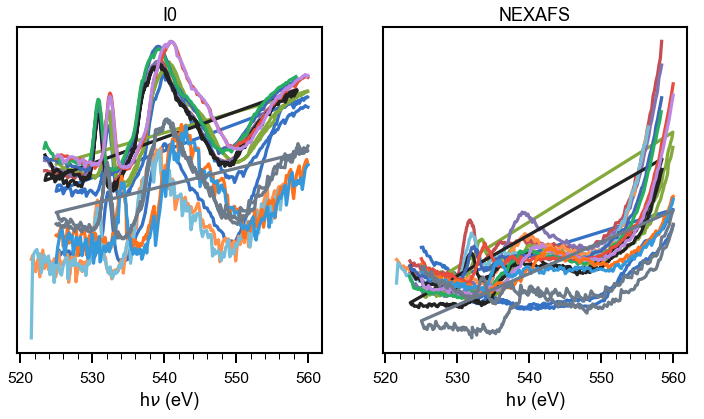

In [804]:
region = f['NEXAFS']['O 1s']
plotNexafs(region)

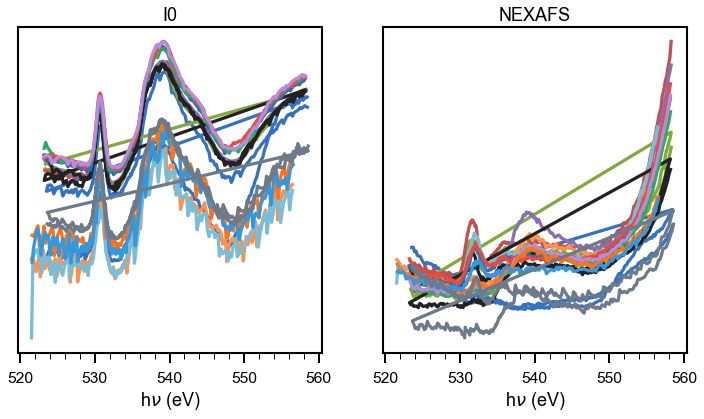

In [805]:
shiftRegion(region, cut=535, refPeak=530.69)

## Shift N 1s

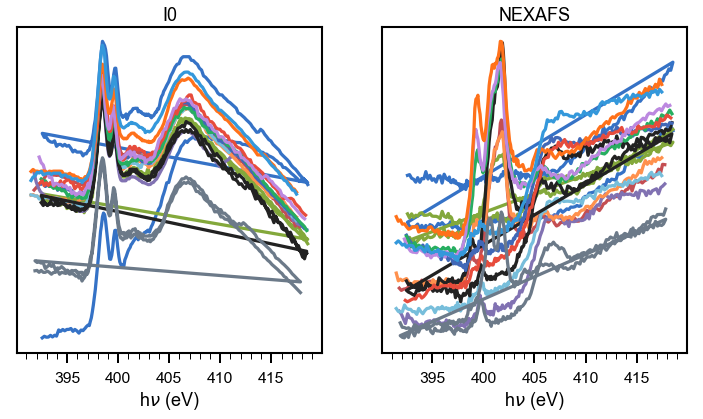

In [183]:
region = f['NEXAFS']['N 1s']
plotNexafs(region)

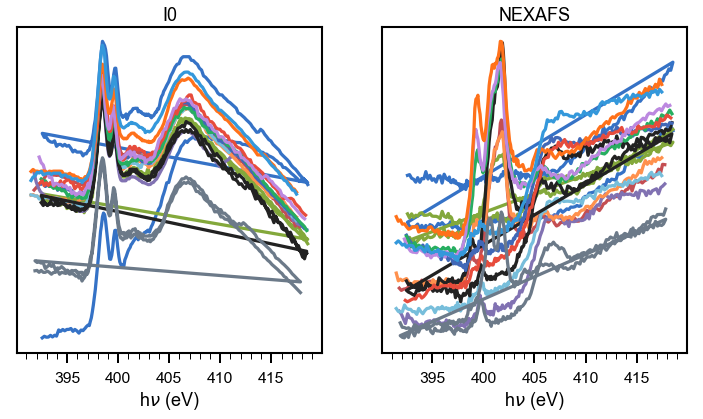

In [807]:
shiftRegion(region, cut=402, refPeak=398.46)

### Script graph Igor

In [186]:
AppendToGraphNXF(region)

AppendToGraph ':'NEXAFS':'N 1s':'CleanAu':'09_11_202105_CleanAu':py_09_11_202105 vs ':'NEXAFS':'N 1s':'CleanAu':'09_11_202105_CleanAu':hn_09_11_202105
AppendToGraph ':'NEXAFS':'N 1s':'FBI-G3 2nd evap':'16_11_202108_G3subML_S+Ppol':py_16_11_202108 vs ':'NEXAFS':'N 1s':'FBI-G3 2nd evap':'16_11_202108_G3subML_S+Ppol':hn_16_11_202108
AppendToGraph ':'NEXAFS':'N 1s':'FBI-G3 2nd evap':'16_11_202121_G3ML_Ppol':py_16_11_202121 vs ':'NEXAFS':'N 1s':'FBI-G3 2nd evap':'16_11_202121_G3ML_Ppol':hn_16_11_202121
AppendToGraph ':'NEXAFS':'N 1s':'FBI-G3 2nd evap':'16_11_202122_G3ML_Spol':py_16_11_202122 vs ':'NEXAFS':'N 1s':'FBI-G3 2nd evap':'16_11_202122_G3ML_Spol':hn_16_11_202122
AppendToGraph ':'NEXAFS':'N 1s':'FBI-G3 2nd evap':'17_11_202116_2minFe_G3ML_Ppol':py_17_11_202116 vs ':'NEXAFS':'N 1s':'FBI-G3 2nd evap':'17_11_202116_2minFe_G3ML_Ppol':hn_17_11_202116
AppendToGraph ':'NEXAFS':'N 1s':'FBI-G3 2nd evap':'17_11_202117_2minFe_G3ML_Spol':py_17_11_202117 vs ':'NEXAFS':'N 1s':'FBI-G3 2nd evap':'17_

In [187]:
ModifyGraph_lSize_NXF(region)

ModifyGraph lSize(py_09_11_202105)=2
ModifyGraph lSize(py_16_11_202108)=2
ModifyGraph lSize(py_16_11_202121)=2
ModifyGraph lSize(py_16_11_202122)=2
ModifyGraph lSize(py_17_11_202116)=2
ModifyGraph lSize(py_17_11_202117)=2
ModifyGraph lSize(py_17_11_202130)=2
ModifyGraph lSize(py_18_11_202111)=2
ModifyGraph lSize(py_18_11_202112)=2
ModifyGraph lSize(py_18_11_202129)=2
ModifyGraph lSize(py_18_11_202130)=2
ModifyGraph lSize(py_19_11_202105)=2
ModifyGraph lSize(py_19_11_202106)=2
ModifyGraph lSize(py_20_11_202114)=2


ModifyGraph rgb( py_09_11_202105 )= (13621, 29298, 50886)
ModifyGraph rgb( py_16_11_202108 )= (33667, 43176, 15163)
ModifyGraph rgb( py_16_11_202121 )= (50372, 20046, 21074)
ModifyGraph rgb( py_16_11_202122 )= (33153, 29298, 45746)
ModifyGraph rgb( py_17_11_202116 )= (65535, 37265, 19789)
ModifyGraph rgb( py_17_11_202117 )= (30583, 48830, 56283)
ModifyGraph rgb( py_17_11_202130 )= (8738, 8738, 8738)
ModifyGraph rgb( py_18_11_202111 )= (16705, 26728, 47031)
ModifyGraph rgb( py_18_11_202112 )= (10023, 44718, 24672)
ModifyGraph rgb( py_18_11_202129 )= (59367, 19532, 15420)
ModifyGraph rgb( py_18_11_202130 )= (48316, 35209, 57568)
ModifyGraph rgb( py_19_11_202105 )= (65535, 29041, 6682)
ModifyGraph rgb( py_19_11_202106 )= (13364, 39064, 56283)
ModifyGraph rgb( py_20_11_202114 )= (27756, 31354, 35209)


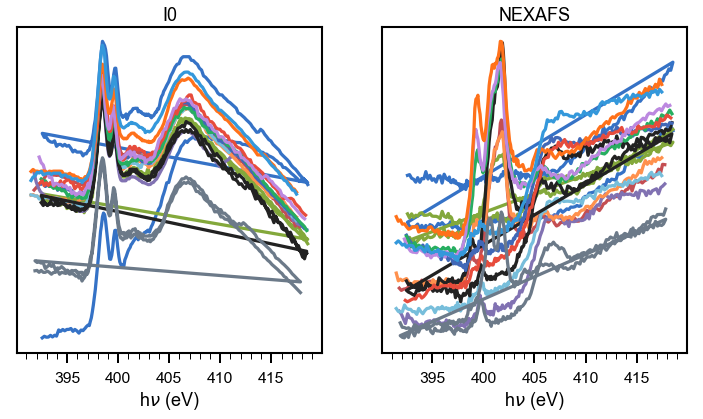

In [185]:
plotNexafs(region, print_color=True)

## C1s

09_11_202103_CleanAu
16_11_202110_G3subML_S+Ppol
16_11_202123_G3ML_Spol
16_11_202124_G3ML_Ppol
17_11_202118_2minFe_G3ML_Spol
17_11_202119_2minFe_G3ML_Ppol
17_11_202129_G3ML_S+Ppol
18_11_202109_3minFe_G3ML_Ppol
18_11_202110_3minFe_G3ML_Spol
b'18_11_202127_125\xba_3min_G3ML_Ppo'
b'18_11_202128_125\xba_3min_G3ML_Spo'
b'19_11_202107_150\xba_6min_G3ML_Spo'
b'19_11_202108_150\xba_6min_G3ML_Ppo'
20_11_202115_G2ML


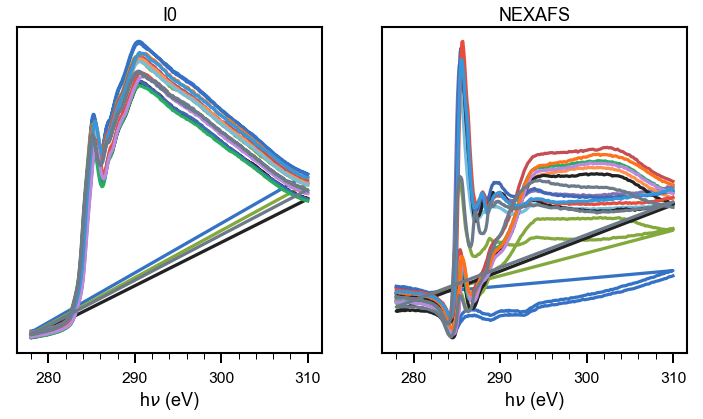

In [808]:
region = f['NEXAFS']['C 1s']

plotNexafs(region)

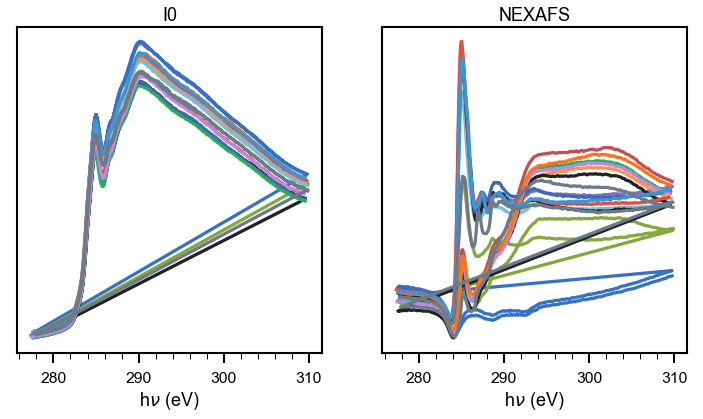

In [809]:
shiftRegion(region, cut=286, refPeak=284.96)

## Fe2p

In [190]:
region = f['NEXAFS']['Fe 2p']

In [819]:
categs = list(region)[:3]
waves = list(region[categs[1]]['17_11_202112_2minFe_G3ML_Ppol'])[26:]
for c,w in enumerate(waves):
    print(w)
    if w != 'py_15_11_202108':
        print(region[categs[1]]['17_11_202112_2minFe_G3ML_Ppol'][c])

In [817]:
categ = list(region)
if region.name == '/NEXAFS/Fe 2p':
    categ = categ[:3]
exps = {}
for c in categ: 
    print(region[c])

<HDF5 group "/NEXAFS/Fe 2p/CleanAu" (1 members)>
<HDF5 group "/NEXAFS/Fe 2p/FBI-G3 2nd evap" (4 members)>
<HDF5 group "/NEXAFS/Fe 2p/FBI-G3 3rd evap" (7 members)>


In [820]:
delits = ['M_Covar', 'V_Flag', 'V_chisq', 'V_endChunk', 'V_endCol', 'V_endLayer', 'V_endRow', 'V_nheld', 'V_npnts', 'V_nterms',
 'V_numINFs', 'V_numNaNs', 'V_startChunk', 'V_startCol', 'V_startLayer', 'V_startRow', 'W_coef', 'W_sigma',
 'fit_i0_15_11_202108', 'fit_i0_16_11_202118', 'fit_i0_16_11_202121', 'fit_i0_17_11_202130', 'fit_i0_18_11_202100',
       'fit_i0_19_11_202101', 'fit_py_17_11_202112', 'hn_15_11_202108',  'py_15_11_202108']
for d in delits:
    region[categs[1]]['17_11_202112_2minFe_G3ML_Ppol'].__delitem__(d)

KeyError: "Couldn't delete link (callback link pointer is NULL (specified link may be '.' or not exist))"

In [821]:
list(region[categs[1]]['17_11_202112_2minFe_G3ML_Ppol'])
region[categs[1]].__delitem__('matchStr')

KeyError: "Couldn't delete link (callback link pointer is NULL (specified link may be '.' or not exist))"

29_09_202104_CleanAu
16_11_202119_G3ML_Spol(ref)
16_11_202120_G3ML_Ppol(ref)
17_11_202112_2minFe_G3ML_Ppol
17_11_202113_2minFe_G3ML_Spol
18_11_202101_G3ML_S+Ppol
18_11_202115_3minFe_G3ML_Spol
18_11_202116_3minFe_G3ML_Ppol
b'18_11_202134_125\xba_3min_G3ML_Spo'
b'18_11_202135_125\xba_3min_G3ML_Ppo'
b'19_11_202101_150\xba_6min_G3ML_Ppo'
b'19_11_202102_150\xba_6min_G3ML_Spo'


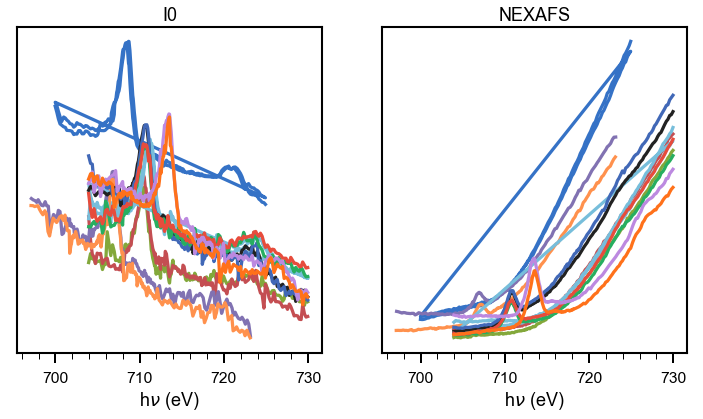

In [822]:
plotNexafs(region)

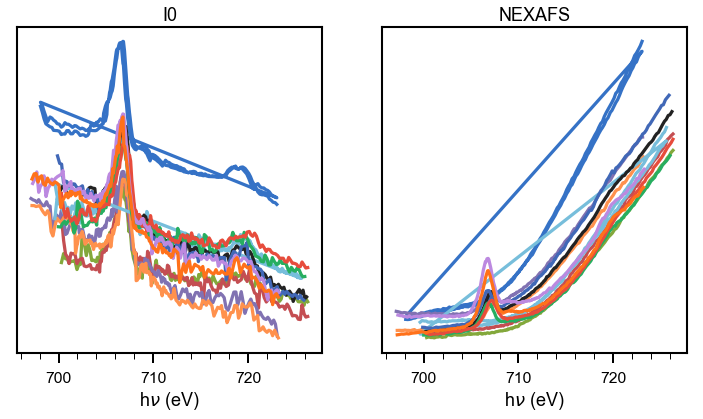

In [823]:
shiftRegion(region, cut=720, refPeak=706.8)

### Script Graph Igor

In [196]:
def AppendToGraphNXF(region, io:bool =False):
    exps = getExps(region)
    flat_exps = []
    for k, v in exps.items():
        for xp in v:
            wn = list(region[k][xp])
            waves = region[k][xp]
            if wn[0] == 'Manipulator(R1)':
                inds = (1, 2, 4)    # hn, i0, py
            else:
                inds = (0, 1, 3)

            if type(xp) == bytes: 
                label = str(waves.name)
                label = label.replace("b'", '')
                label = label.replace('\\xba', 'º')
            else: label = waves.name
    #         print(label)
            if io:
                print('AppendToGraph '+label.replace('/', "':'")+"':" + wn[inds[1]] + ' vs ' + label.replace('/', "':'") +"':"+wn[inds[0]])
            else:
                print('AppendToGraph '+label.replace('/', "':'")+"':" + wn[inds[2]] + ' vs ' + label.replace('/', "':'") +"':"+wn[inds[0]])

                
def AlignNXF(region, io:bool =False):
    exps = getExps(region)
    flat_exps = []
    for k, v in exps.items():
        for xp in v:
            wn = list(region[k][xp])
            waves = region[k][xp]
            if wn[0] == 'Manipulator(R1)':
                inds = (1, 2, 4)    # hn, i0, py
            else:
                inds = (0, 1, 3)

            if type(xp) == bytes: 
                label = str(waves.name)
                label = label.replace("b'", '')
                label = label.replace('\\xba', 'º')
            else: label = waves.name
    #         print(label)
            label = label.replace('/', "':'").replace("':'NEXAFS'", "root:NEXAFS")
            print('AlignFolder("'+label+'")')

def ModifyGraph_lSize_NXF(region):
    exps = getExps(region)
    flat_exps = []
    for k, v in exps.items():
        for xp in v:
            wn = list(region[k][xp])
            waves = region[k][xp]
            if wn[0] == 'Manipulator(R1)':
                inds = (1, 2, 4)    # hn, i0, py
            else:
                inds = (0, 1, 3)
            if type(xp) == bytes: 
                label = str(waves.name)
                label = label.replace("b'", '')
                label = label.replace('\\xba', 'º')
            else: label = waves.name
    #         print(label)
            print('ModifyGraph lSize('+ wn[inds[2]] + ')=2')

In [197]:
AlignNXF(region)

AlignFolder("root:NEXAFS:'Fe 2p':'CleanAu':'29_09_202104_CleanAu")
AlignFolder("root:NEXAFS:'Fe 2p':'FBI-G3 2nd evap':'16_11_202119_G3ML_Spol(ref)")
AlignFolder("root:NEXAFS:'Fe 2p':'FBI-G3 2nd evap':'16_11_202120_G3ML_Ppol(ref)")
AlignFolder("root:NEXAFS:'Fe 2p':'FBI-G3 2nd evap':'17_11_202112_2minFe_G3ML_Ppol")
AlignFolder("root:NEXAFS:'Fe 2p':'FBI-G3 2nd evap':'17_11_202113_2minFe_G3ML_Spol")
AlignFolder("root:NEXAFS:'Fe 2p':'FBI-G3 3rd evap':'18_11_202101_G3ML_S+Ppol")
AlignFolder("root:NEXAFS:'Fe 2p':'FBI-G3 3rd evap':'18_11_202115_3minFe_G3ML_Spol")
AlignFolder("root:NEXAFS:'Fe 2p':'FBI-G3 3rd evap':'18_11_202116_3minFe_G3ML_Ppol")
AlignFolder("root:NEXAFS:'Fe 2p':'FBI-G3 3rd evap':'18_11_202134_125º_3min_G3ML_Spo'")
AlignFolder("root:NEXAFS:'Fe 2p':'FBI-G3 3rd evap':'18_11_202135_125º_3min_G3ML_Ppo'")
AlignFolder("root:NEXAFS:'Fe 2p':'FBI-G3 3rd evap':'19_11_202101_150º_6min_G3ML_Ppo'")
AlignFolder("root:NEXAFS:'Fe 2p':'FBI-G3 3rd evap':'19_11_202102_150º_6min_G3ML_Spo'")


In [104]:
AppendToGraphNXF(region)

AppendToGraph ':'NEXAFS':'Fe 2p':'CleanAu':'29_09_202104_CleanAu':py_29_09_202104 vs ':'NEXAFS':'Fe 2p':'CleanAu':'29_09_202104_CleanAu':hn_29_09_202104
AppendToGraph ':'NEXAFS':'Fe 2p':'FBI-G3 2nd evap':'16_11_202119_G3ML_Spol(ref)':py_16_11_202119 vs ':'NEXAFS':'Fe 2p':'FBI-G3 2nd evap':'16_11_202119_G3ML_Spol(ref)':hn_16_11_202119
AppendToGraph ':'NEXAFS':'Fe 2p':'FBI-G3 2nd evap':'16_11_202120_G3ML_Ppol(ref)':py_16_11_202120 vs ':'NEXAFS':'Fe 2p':'FBI-G3 2nd evap':'16_11_202120_G3ML_Ppol(ref)':hn_16_11_202120
AppendToGraph ':'NEXAFS':'Fe 2p':'FBI-G3 2nd evap':'17_11_202112_2minFe_G3ML_Ppol':py_17_11_202112 vs ':'NEXAFS':'Fe 2p':'FBI-G3 2nd evap':'17_11_202112_2minFe_G3ML_Ppol':hn_17_11_202112
AppendToGraph ':'NEXAFS':'Fe 2p':'FBI-G3 2nd evap':'17_11_202113_2minFe_G3ML_Spol':py_17_11_202113 vs ':'NEXAFS':'Fe 2p':'FBI-G3 2nd evap':'17_11_202113_2minFe_G3ML_Spol':hn_17_11_202113
AppendToGraph ':'NEXAFS':'Fe 2p':'FBI-G3 3rd evap':'18_11_202101_G3ML_S+Ppol':py_18_11_202101 vs ':'NEXAFS'

In [105]:
ModifyGraph_lSize_NXF(region)

ModifyGraph lSize(py_29_09_202104)=2
ModifyGraph lSize(py_16_11_202119)=2
ModifyGraph lSize(py_16_11_202120)=2
ModifyGraph lSize(py_17_11_202112)=2
ModifyGraph lSize(py_17_11_202113)=2
ModifyGraph lSize(py_18_11_202101)=2
ModifyGraph lSize(py_18_11_202115)=2
ModifyGraph lSize(py_18_11_202116)=2
ModifyGraph lSize(py_18_11_202134)=2
ModifyGraph lSize(py_18_11_202135)=2
ModifyGraph lSize(py_19_11_202101)=2
ModifyGraph lSize(py_19_11_202102)=2


ModifyGraph rgb( py_29_09_202104 )= (13621, 29298, 50886)
ModifyGraph rgb( py_16_11_202119 )= (33667, 43176, 15163)
ModifyGraph rgb( py_16_11_202120 )= (50372, 20046, 21074)
ModifyGraph rgb( py_17_11_202112 )= (33153, 29298, 45746)
ModifyGraph rgb( py_17_11_202113 )= (65535, 37265, 19789)
ModifyGraph rgb( py_18_11_202101 )= (30583, 48830, 56283)
ModifyGraph rgb( py_18_11_202115 )= (8738, 8738, 8738)
ModifyGraph rgb( py_18_11_202116 )= (16705, 26728, 47031)
ModifyGraph rgb( py_18_11_202134 )= (10023, 44718, 24672)
ModifyGraph rgb( py_18_11_202135 )= (59367, 19532, 15420)
ModifyGraph rgb( py_19_11_202101 )= (48316, 35209, 57568)
ModifyGraph rgb( py_19_11_202102 )= (65535, 29041, 6682)


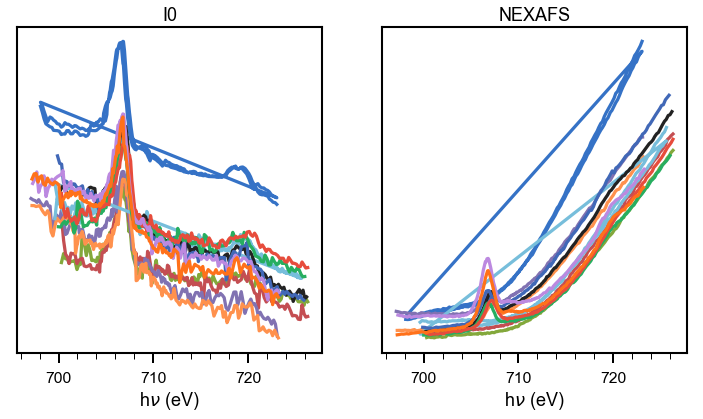

In [117]:
plotNexafs(region, print_color=True)

# XPS

In [725]:
filename = "/Users/pabloherrero/sabat/xps_spectra/ALOISA/Test.h5"

f = h5py.File(filename, "r+", driver=None)
    # List all groups
print("Keys: %s" % f.keys())

    # Get the data
# nxf = list(f['NEXAFS']['C 1s'])

Keys: <KeysViewHDF5 ['15_11_202108 s-pol', 'NEXAFS', 'Packages', 'TXPS', 'V_Flag', 'W_DIF', 'WinGlobals', 'XPS', 'multi_matr', 'okj', 'py_15_11_202108 p-pol']>


In [101]:
def AppendToGraph(region):
    exps = getExps(region)
    flat_exps = []
    for k, v in exps.items():
        for xp in v:
            wn = list(region[k][xp])
            waves = region[k][xp]
            if type(xp) == bytes: 
                label = str(waves.name)
                label = label.replace("b'", '')
                label = label.replace('\\xba', 'º')
            else: label = waves.name
    #         print(label)
            print('AppendToGraph '+label.replace('/', "':'")+"':" + wn[0] + ' vs ' + label.replace('/', "':'") +"':"+wn[1])

def ModifyGraph_lSize(region):
    exps = getExps(region)
    flat_exps = []
    for k, v in exps.items():
        for xp in v:
            wn = list(region[k][xp])
            waves = region[k][xp]
            if type(xp) == bytes: 
                label = str(waves.name)
                label = label.replace("b'", '')
                label = label.replace('\\xba', 'º')
            else: label = waves.name
    #         print(label)
            print('ModifyGraph lSize('+ wn[0] + ')=2')
        
def plotXpsRegion(region, print_color: bool = False):
    exps = getExps(region)
    inds = (0, 1)
    ax = plt.gca()
    for k, v in exps.items():
        for xp in v:
            wn = list(region[k][xp])
            waves = region[k][xp]

            cnts, ebin = (np.array(waves[wn[i]])  for i in inds)
            label=setLabel(xp)

            col = ax.plot(ebin, cnts, label=label)[0].get_color().lstrip('#')
            if print_color: 
                print('rgb(', wn[0], ')=', tuple(int(int(col[i:i+2], 16)*65535/255) for i in (0, 2, 4)))

def setLabel(xp):
    if type(xp) == bytes: 
        label = str(xp)
        label = label.replace("b'", '')
        label = label.replace('\\xba', 'º')
    else: label = xp
    label = label.replace('_11_2021', '_')
    return label

def plotFermi(region, fermiCut = 2.2e-4, width = 20, b0 = 2.607466764007832e-05, inplace: bool = False):
    exps = getExps(region)
    inds = (0, 1)
    fig, ax = plt.subplots(3, 2, figsize=(24, 18))
    cnavg = np.zeros(width)
    lenxp = 0
    for k, v in exps.items():
        for xp in v:
            wn = list(region[k][xp])
            waves = region[k][xp]
            cnts, ebin = (np.array(waves[wn[i]])  for i in inds)
            vbcut = np.where(ebin[:-1] - ebin[1:] > 1)[0][0]

            cnts = cnts[np.where(ebin < 50)]            
            ebin = ebin[np.where(ebin < 50)]

            ebin = ebin[np.where(cnts < fermiCut)[0][:width]]
            cnts = cnts[np.where(cnts < fermiCut)[0][:width]]
            if len(cnts) == 0:
                pass
            else:
                deriv = cnts[:-1]-cnts[1:]
                label=setLabel(xp)

                ax[0,0].plot(ebin, cnts, label=label)
                ax[0,1].plot(ebin[1:], deriv, label=label)
                edge = np.argmax(deriv)
                shift = ebin[edge]
                ebin -= ebin[edge]
                ax[1,0].plot(ebin, cnts, 'o', label=label)
                ax[1,1].plot(ebin[1:], deriv, 'o', label=label)
                
                cnavg += cnts
                lenxp += 1
                
                mod = PolynomialModel(prefix='', degree=3)
                par1 = mod.guess(cnts, x=ebin)
                fit1 = mod.fit(cnts, par1, x=ebin)

                ax[1,0].plot(ebin, fit1.best_fit, '-')
                
                a1, b1 = (fit1.best_values['c3'], fit1.best_values['c2'])
                x0 = (b0-b1)/(3*a1)
                print(xp, x0)
                shift += x0
                ebin -= x0
                ax[2,0].plot(ebin, cnts, '-')
                if inplace: waves[wn[1]][:] -= shift
    print(vbcut)        
    cnavg /= lenxp
    ebavg = ebin
    
    for a in ax[:,1]: a.set(yticks=[])
        
    return ebavg, cnavg

## O 1s shift

In [82]:
region = f['XPS']['O 1s']

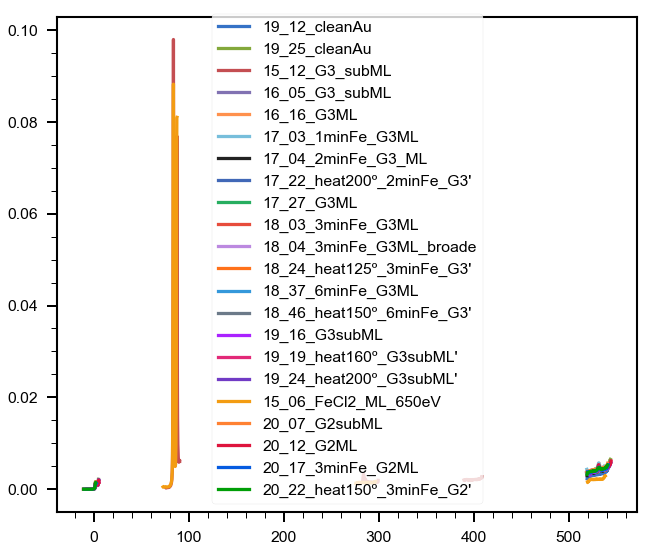

In [45]:
plotXpsRegion(region)
# plt.gca().set(xlim=(-1, 1), ylim=(0, 0.002))
plt.legend()

In [21]:
list(region['G2']['20_11_202117_3minFe_G2ML'])

['wCnts_20_11_202117',
 'wEbin_20_11_202117',
 'wEkin_20_11_202117',
 'wI0MCP_20_11_202117']

### Shift

19_11_202112_cleanAu -1.0950086348923047
19_11_202125_cleanAu -0.7589926727770686
16_11_202105_G3_subML -1.0264554645377004
16_11_202116_G3ML -0.9934544551970483
17_11_202103_1minFe_G3ML -0.8067461567393807
17_11_202104_2minFe_G3_ML -1.1161305099536618
b'17_11_202122_heat200\xba_2minFe_G3' -0.9816741179800175
17_11_202127_G3ML -1.0766510908086344
18_11_202103_3minFe_G3ML -1.044471427042607
18_11_202104_3minFe_G3ML_broade -1.0543759431411868
b'18_11_202124_heat125\xba_3minFe_G3' -0.9941260843005751
18_11_202137_6minFe_G3ML -0.9427694684293652
b'18_11_202146_heat150\xba_6minFe_G3' -0.8554122525082821
19_11_202116_G3subML -1.0103184669283853
b'19_11_202119_heat160\xba_G3subML' -0.9607382881677498
b'19_11_202124_heat200\xba_G3subML' -0.8839229191999964
20_11_202107_G2subML -0.6961170569147833
20_11_202112_G2ML -1.006377464769207
20_11_202117_3minFe_G2ML -1.0089260087899306
b'20_11_202122_heat150\xba_3minFe_G2' -0.9697129736803423
145


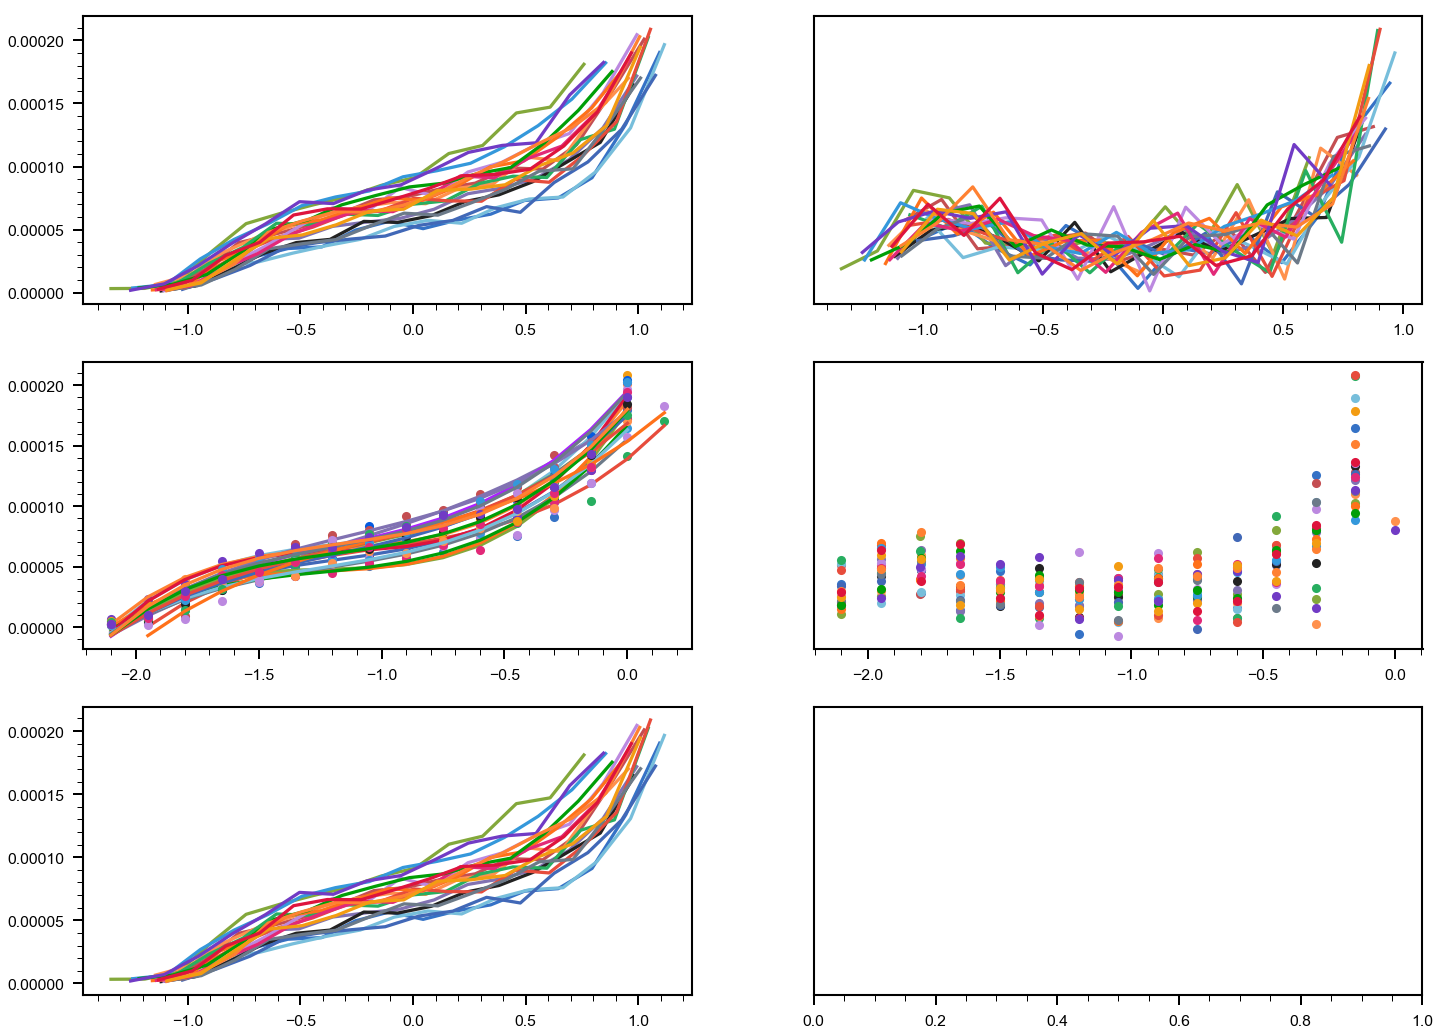

In [826]:
ebavg, cnavg = plotFermi(region, fermiCut=2.2e-4, width=15, inplace=True)
# plt.gca().legend()

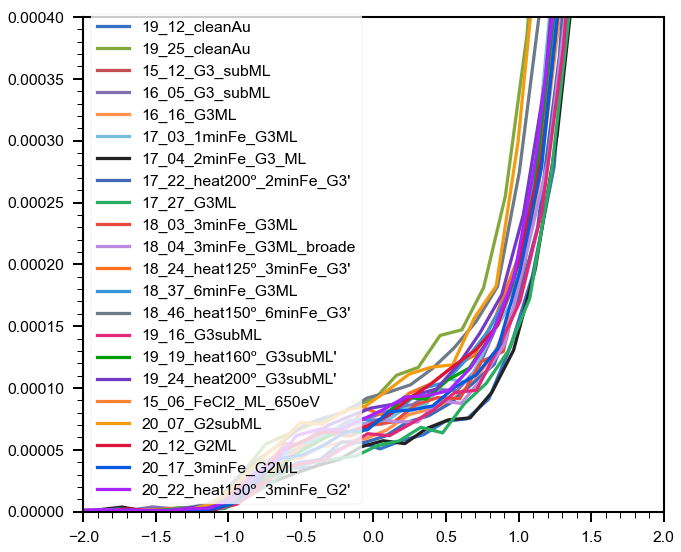

In [720]:
plotXpsRegion(region)
plt.gca().set(xlim=(-2, 2), ylim=(0, 4e-4))
plt.legend()

[(0, 0.002), (-2, 7)]

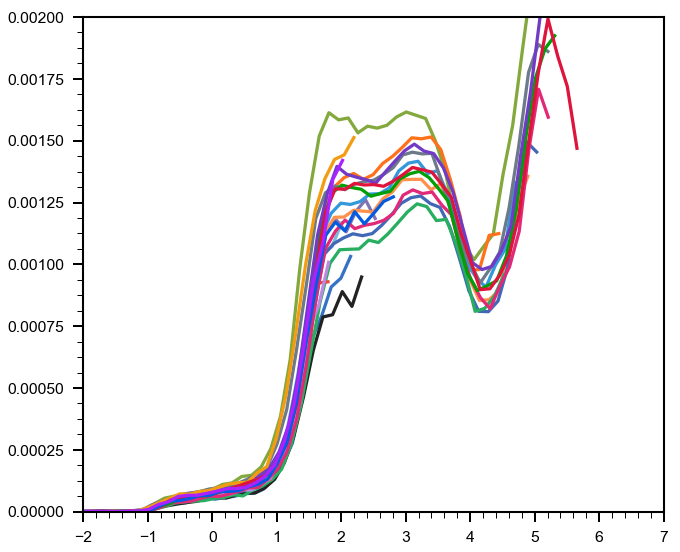

In [724]:
plotXpsRegion(region)
plt.gca().set(xlim=(-2, 7), ylim=(0, 2e-3))

In [414]:
list(region['FBI-G3 4th evap (subML)'])

['19_11_202116_G3subML',
 b'19_11_202119_heat160\xba_G3subML',
 b'19_11_202124_heat200\xba_G3subML']

In [712]:
# eb = np.array(region['G2']['20_11_202117_3minFe_G2ML'])
list(region['G2']['20_11_202117_3minFe_G2ML'])

['wCnts_20_11_202117',
 'wEbin_20_11_202117',
 'wEkin_20_11_202117',
 'wI0MCP_20_11_202117']

In [46]:
eb = region['G2']['20_11_202117_3minFe_G2ML']['wEbin_20_11_202117'][:]
cn = region['G2']['20_11_202117_3minFe_G2ML']['wCnts_20_11_202117'][:]
ek = region['G2']['20_11_202117_3minFe_G2ML']['wEkin_20_11_202117'][:]

eb2 = region['FBI-G3 4th evap (subML)']['19_11_202116_G3subML']['wEbin_19_11_202116'][:]
# ek = region['FBI-G3 1st evap (subML)']['15_11_202112_G3_subML']['wEkin_15_11_202112'][:]
cn2 = region['FBI-G3 4th evap (subML)']['19_11_202116_G3subML']['wCnts_19_11_202116'][:]


In [370]:
fermicut = 20
eb[np.where(eb < fermicut)]
cn[np.where(eb < fermicut)]

array([], dtype=float64)

In [430]:
2/0.15

13.333333333333334

In [440]:
vbcut = np.where(cn < 1.2e-4)[0][:20]
eb[vbcut]

array([9.326911 , 9.176948 , 9.026923 , 8.876899 , 8.726935 , 8.576911 ,
       8.426948 , 8.276923 , 8.126899 , 7.9769354, 7.826911 , 7.6769476,
       7.526923 , 7.376899 , 7.2269354, 7.076911 , 6.9269476, 6.776923 ,
       6.626899 , 6.4769354], dtype=float32)

In [551]:
# vbcut = np.where(eb[:-1] - eb[1:] > 1)[0][0]
vbcut = np.where(cn < 2.2e-4)[0][:15]
evb = eb[vbcut]
kvb = ek[vbcut]
cvb = cn[vbcut]

In [552]:
# vbcut = np.where(eb2[:-1] - eb2[1:] > 1)[0][0]
vbcut = np.where(cn2 < 2.2e-4)[0][:15]

evb2 = eb2[vbcut]
kvb2 = ek2[vbcut]
cvb2 = cn2[vbcut]

[[]]

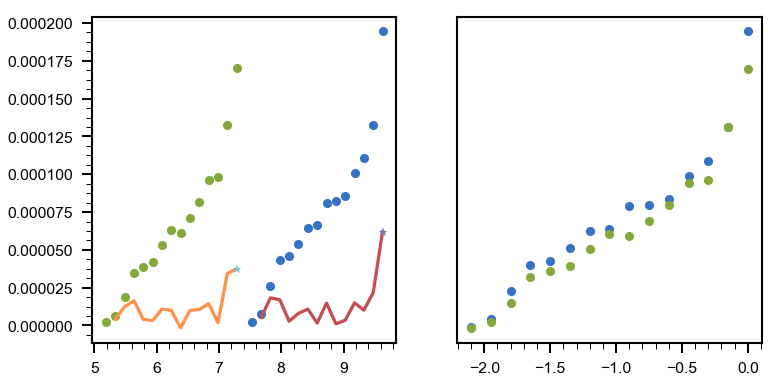

In [554]:
zero = np.where(cvb[1:]-cvb[:-1] < 1e-6)
jump = np.where((cvb[1:]-cvb[:-1] < 1e-6) & (cvb[1:]-cvb[:-1] > 1e-7) )

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(evb, cvb, 'o')
ax[0].plot(evb2, cvb2, 'o')

deriv = cvb[:-1]-cvb[1:]
ax[0].plot(evb[:-1], deriv)
edge = np.argmax(deriv)
ax[0].plot(evb[edge], deriv[edge], '*')

deriv2 = cvb2[:-1]-cvb2[1:]
ax[0].plot(evb2[:-1], deriv2)
edge2 = np.argmax(deriv2)
ax[0].plot(evb2[edge2], deriv2[edge2], '*')

evb -= evb[edge]
evb2 -= evb2[edge2]
ax[1].plot(evb, cvb, 'o')
ax[1].plot(evb2, cvb2, 'o')
ax[1].set(yticks=[])

In [442]:
from scipy.optimize import curve_fit
from scipy.special import erf, erfc

In [452]:
np.min(cvb), 2.84*0.4

(1.296275840752269e-07, 1.136)

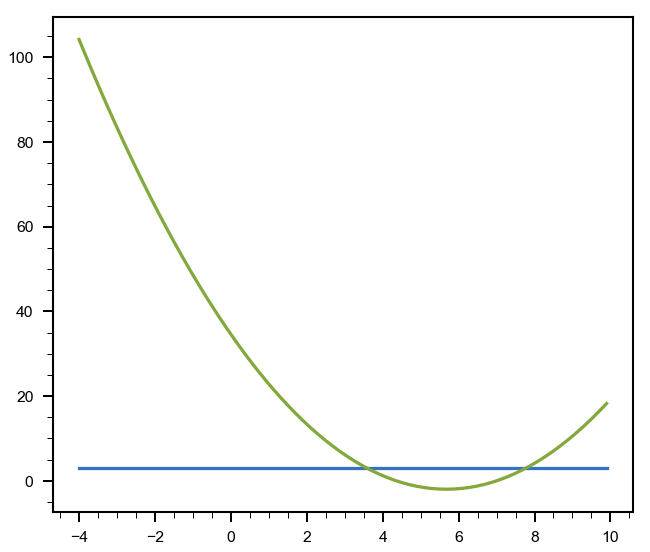

In [537]:
def errf(x, x0, a, b, c):
    return a/2*erf((x-x0)/b)+c
    
def cube(x, x0, a, b, c, d):
    y = x-x0
    return a*y**3 + b*y**2 + c*y + d

def cubex0(x, x0):
    y = x-x0
    return a*y**3 + b*y**2 + c*y + d

p0 = [7, np.max(cvb), 2.84*0.4, 3, 1e-4]
x = np.arange(-4, 10, 0.1)
plt.plot(x,  errf(x, *p0[:-1]))
plt.plot(x,  cube(x, *p0))

(array([-0.9]), array([-0.9]))

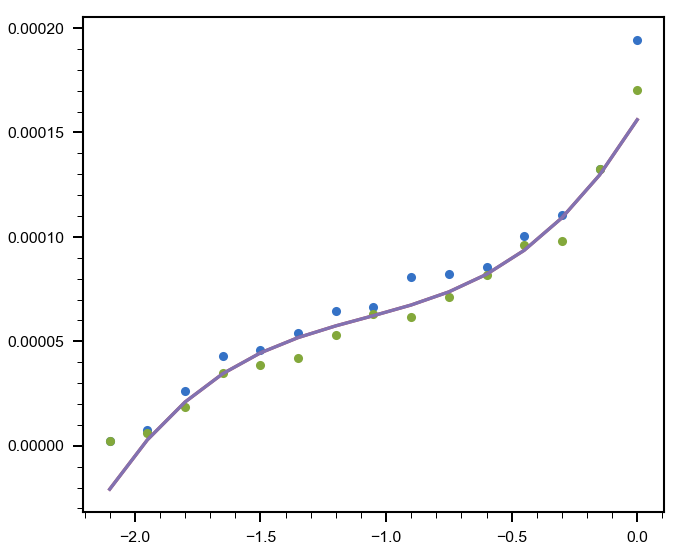

In [569]:
plt.plot(evb, cvb, 'o')
plt.plot(evb2, cvb2, 'o')
scale = np.max(evb)
p0 = [-0.9]
bounds = (-1.5, -0.5)

popt, pcov = curve_fit(lambda x, x0: cube(x, x0, *popt3[1:]),
                       evb, cvb, p0=p0)#, bounds=bounds)
# popt2, pcov2 = curve_fit(cube, evb2, cvb2, p0=p0, bounds=bounds)
popt2, pcov2 = curve_fit(lambda x, x0: cube(x, x0, *popt3[1:]),
                       evb2, cvb2, p0=p0)#, bounds=bounds)

plt.plot(evb, cube(evb, popt[0], *popt3[1:]))
plt.plot(evb2, cube(evb2, popt2[0], *popt3[1:]))
popt, popt2

In [577]:
from lmfit.model import ModelResult
from lmfit.models import PseudoVoigtModel, PolynomialModel, ExpressionModel

In [498]:
mxc, mxc*0.99

(0.0001862458996249497, 0.0001843834406287002)

array([-1.00000000e+00,  1.86245900e-04,  1.13600000e+00,  7.70695715e-05])

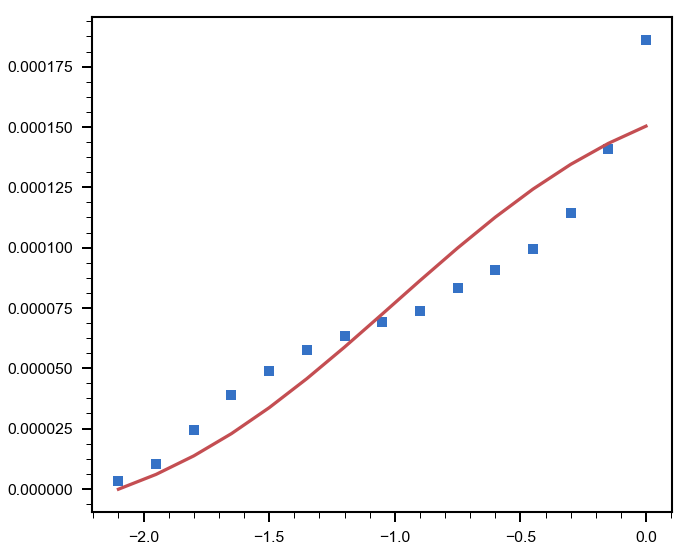

In [525]:
plt.plot(ebavg, cnavg, 's')
mxc, mnc = np.max(cnavg), np.min(cnavg)
p0 = [-1, mxc, 2.84*0.4, 0]
bounds = [(-1.5, -0.5), (mxc, mxc), (2.84*0.25, 2.84*0.45), (0, np.min(cnavg))]
bounds = ([-1.5, mxc*0.99, 2.84*0.35, -0.99*mnc], [-0.5, mxc, 2.84*0.45, mnc])
popt3, pcov3 = curve_fit(errf, ebavg, cnavg, p0=p0,)# bounds=bounds)
plt.plot(ebavg, errf(ebavg, *popt3), 'r')
popt3

array([-1.00000000e+00,  4.71558198e-05,  2.60765289e-05,  3.68760164e-05,
        6.74006605e-05])

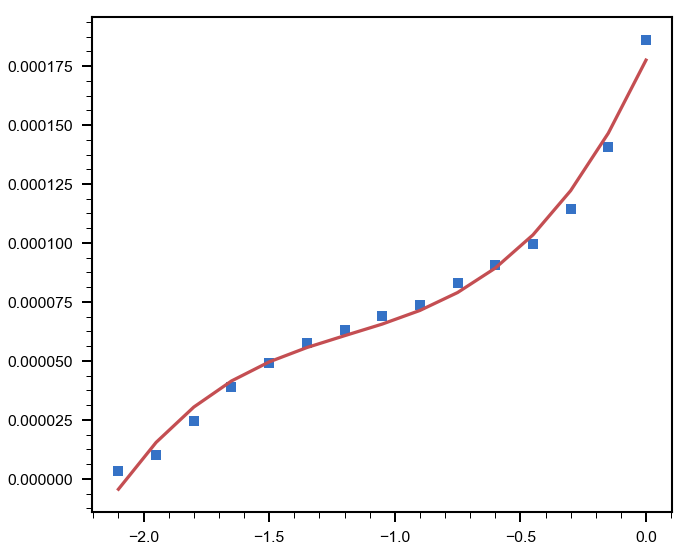

In [547]:
plt.plot(ebavg, cnavg, 's')
mxc, mnc = np.max(cnavg), np.min(cnavg)
scale = np.max(evb)
p0 = [-1, scale, scale, scale, 0]
bounds = ([-1.5, -np.inf,-np.inf,-np.inf,-np.inf], [-0.5, np.inf,np.inf,np.inf,np.inf])
popt3, pcov3 = curve_fit(cube, ebavg, cnavg, p0=p0,)# bounds=bounds)
plt.plot(ebavg, cube(ebavg, *popt3), 'r')
popt3

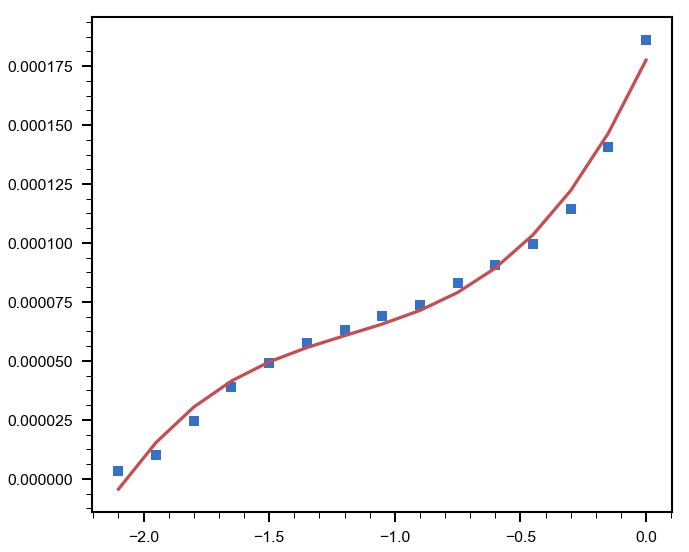

In [614]:
plt.plot(ebavg, cnavg, 's')
mxc, mnc = np.max(cnavg), np.min(cnavg)

mod = PolynomialModel(prefix='', degree=3)

pars = mod.guess(cnavg, x=ebavg)
#     pars[prefix+'sigma'].set(value=1) # Usually guessed wrong anyway
fitv = mod.fit(cnavg, pars, x=ebavg)
plt.plot(ebavg, fitv.best_fit, 'r')
fitv

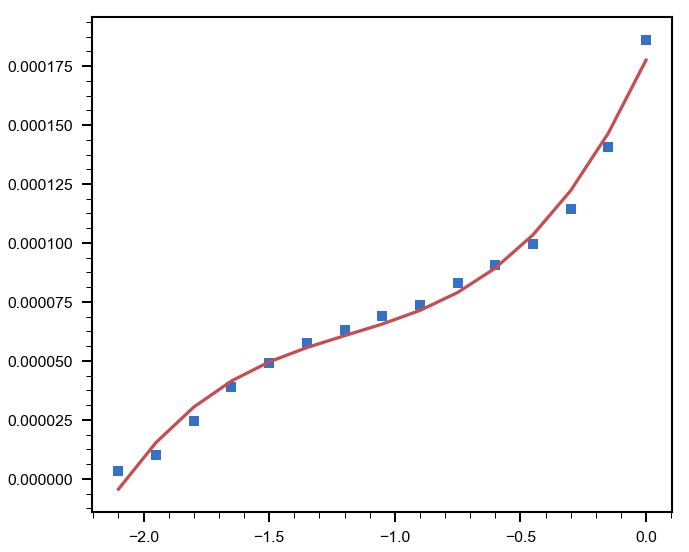

In [643]:
plt.plot(ebavg, cnavg, 's')

modm = ExpressionModel(' c0 + c1 * (x-x0) + c2* (x-x0)**2 + c3 * (x-x0)**3 ')
# mod = PolynomialModel(prefix='v0_', degree=3)

# for i in range(4):
#     modm.set_param_hint('c'+str(i), value=fitv.best_values['c'+str(i)])

x0 = -1
c = [fitv.best_values['c'+str(i)] for i in range(4)]
modm.set_param_hint('x0', value=x0)
modm.set_param_hint('c3', value=c[3])
modm.set_param_hint('c2', value=c[2]+3*x0*c[3])
modm.set_param_hint('c1', value=c[1]+2*c[2]*x0+3*c[3]*x0**2)
modm.set_param_hint('c0', value=c[0]+c[1]*x0+c[3]*x0**3+c[2]*x0**2)

parsm = modm.make_params()
fitm = modm.fit(cnavg, parsm, x=ebavg)
plt.plot(ebavg, fitm.best_fit, 'r')
fitm

In [656]:
par1.values()

odict_values([<Parameter 'c0', 6.740003963649177e-05, bounds=[-inf:inf]>, <Parameter 'c1', 3.6877879296494875e-05, bounds=[-inf:inf]>, <Parameter 'x0', -inf, bounds=[-inf:inf]>, <Parameter 'c2', 2.607466764007832e-05, bounds=[-inf:inf]>, <Parameter 'c3', 4.7156438234837654e-05, bounds=[-inf:inf]>])

({'c0': 0.0001794128488885117,
  'c1': 0.00024648497195885205,
  'c2': 0.00018655683312823542,
  'c3': 5.3020791115175896e-05},
 {'c0': 0.00016313276008313984,
  'c1': 0.00021093933595497862,
  'c2': 0.00014450338926280177,
  'c3': 3.907306639749466e-05})

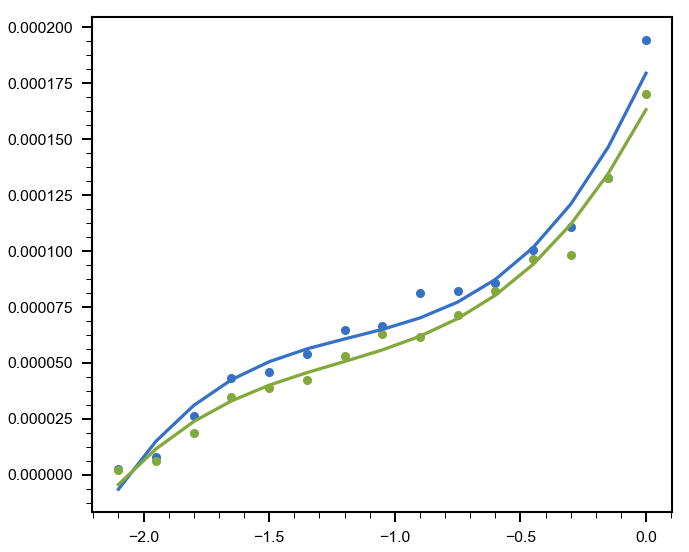

In [671]:
plt.plot(evb, cvb, 'o')
plt.plot(evb2, cvb2, 'o')

mod = PolynomialModel(prefix='', degree=3)

par1 = mod.guess(cvb, x=evb)
par2 = mod.guess(cvb2, x=evb2)

fit1 = mod.fit(cvb, par1, x=evb)
fit2 = mod.fit(cvb2, par2, x=evb2)

plt.plot(evb, fit1.best_fit, 'b')
plt.plot(evb2, fit2.best_fit,'g')
fit1.best_values, fit2.best_values

In [678]:
b0

2.607466764007832e-05

In [677]:
b0 = fitm.best_values['c2']
b1 = fit1.best_values['c2']
b2 = fit2.best_values['c2']
(b0-b1)/(3*a1), (b0-b2)/(3*a2), (b0-b1)/(3*a0), (b0-b2)/(3*a0)

(-1.0089260087899306,
 -1.0103184669283853,
 -1.1343955812845796,
 -0.8371336347397001)

In [675]:
a0 = fitm.best_values['c3']
a1 = fit1.best_values['c3']
a2 = fit2.best_values['c3']
a0, a1, a2

(4.7156438234837654e-05, 5.3020791115175896e-05, 3.907306639749466e-05)

({'c0': 6.740003963649177e-05,
  'c1': 3.6877879296494875e-05,
  'x0': -1.1,
  'c2': 2.607466764007832e-05,
  'c3': 4.7156438234837654e-05},
 {'c0': 6.740003963649177e-05,
  'c1': 3.6877879296494875e-05,
  'x0': -1.1,
  'c2': 2.607466764007832e-05,
  'c3': 4.7156438234837654e-05})

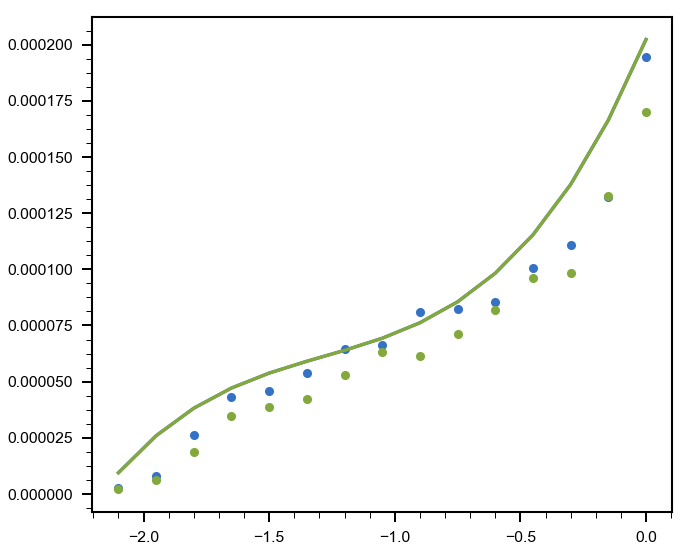

In [665]:
plt.plot(evb, cvb, 'o')
plt.plot(evb2, cvb2, 'o')

modm = ExpressionModel(' c0 + c1 * (x-x0) + c2* (x-x0)**2 + c3 * (x-x0)**3 ')
# mod = PolynomialModel(prefix='v0_', degree=3)
par1 = modm.make_params()
x0 = -1.1
modm.set_param_hint('x0', value=x0, min=-2, max=0)

for i in range(4):
    par1['c'+str(i)].set(value=fitm.best_values['c'+str(i)], )
    par1['c'+str(i)].vary = False
par1['x0'].set(value=x0)
fit1 = modm.fit(cvb, par1, x=evb)
fit2 = modm.fit(cvb2, par1, x=evb2)


plt.plot(evb, fit1.best_fit, 'b')
plt.plot(evb2, fit2.best_fit,'g')
fit1.best_values, fit2.best_values

({'x0': -1.1}, {'x0': -1.1})

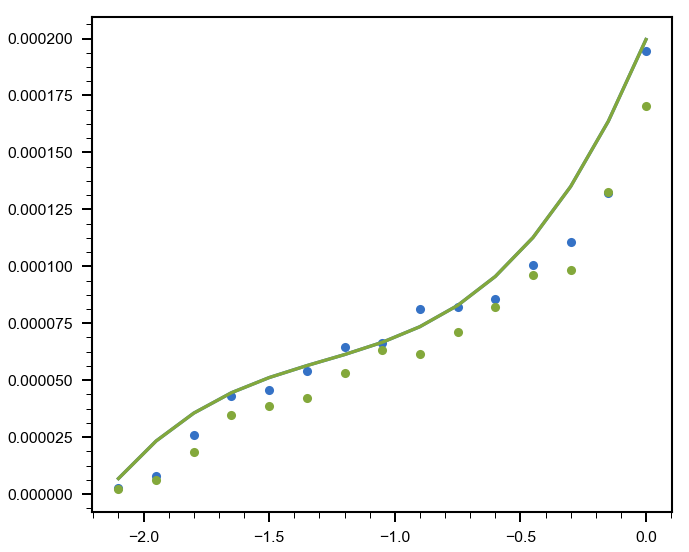

In [669]:
plt.plot(evb, cvb, 'o')
plt.plot(evb2, cvb2, 'o')

modm = ExpressionModel(' 6.47e-5 + 3.68e-5 * (x-x0) + 2.61e-5* (x-x0)**2 + 4.72e-5 * (x-x0)**3 ')
# mod = PolynomialModel(prefix='v0_', degree=3)
par1 = modm.make_params()
x0 = -1.1
modm.set_param_hint('x0', value=x0, min=-2, max=0)

# for i in range(4):
#     par1['c'+str(i)].set(value=fitm.best_values['c'+str(i)], )
#     par1['c'+str(i)].vary = False
par1['x0'].set(value=x0, min=-2, max=0)
fit1 = modm.fit(cvb, par1, x=evb)
fit2 = modm.fit(cvb2, par1, x=evb2)


plt.plot(evb, fit1.best_fit, 'b')
plt.plot(evb2, fit2.best_fit,'g')
fit1.best_values, fit2.best_values

'3572C6'

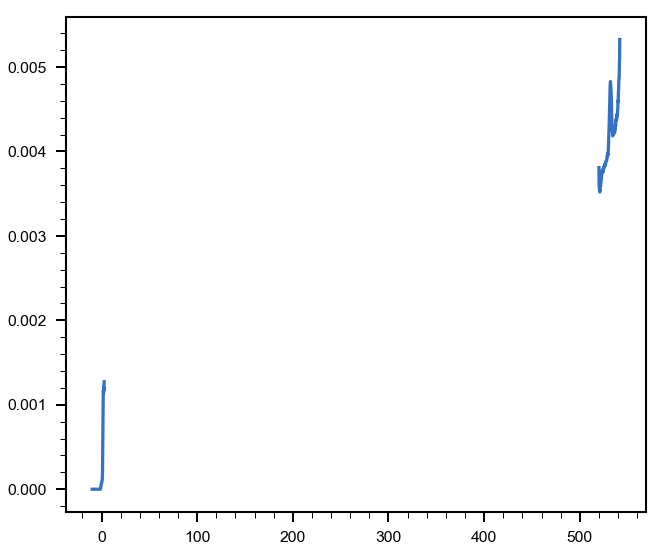

In [62]:
li = plt.plot(eb, cn)[0].get_color().lstrip('#')
# print('RGB =', tuple(int(li[i:i+2], 16) for i in (0, 2, 4)))
li

### Plot after shift

[(0, 0.007), (520, 540)]

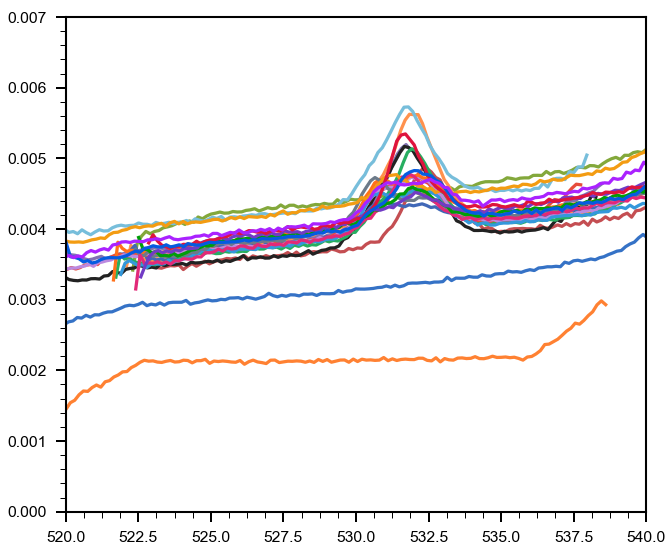

In [794]:
plotXpsRegion(region)
plt.gca().set(xlim=(520, 540), ylim=(0, 0.007))
# plt.legend()

### Script igor

In [86]:
AppendToGraph(region)

AppendToGraph ':'XPS':'O 1s':'CleanAu':'19_11_202112_cleanAu:wCnts_19_11_202112 vs ':'XPS':'O 1s':'CleanAu':'19_11_202112_cleanAu:wEbin_19_11_202112
AppendToGraph ':'XPS':'O 1s':'CleanAu':'19_11_202125_cleanAu:wCnts_19_11_202125 vs ':'XPS':'O 1s':'CleanAu':'19_11_202125_cleanAu:wEbin_19_11_202125
AppendToGraph ':'XPS':'O 1s':'FBI-G3 1st evap (subML)':'15_11_202112_G3_subML:wCnts_15_11_202112 vs ':'XPS':'O 1s':'FBI-G3 1st evap (subML)':'15_11_202112_G3_subML:wEbin_15_11_202112
AppendToGraph ':'XPS':'O 1s':'FBI-G3 2nd evap':'16_11_202105_G3_subML:wCnts_16_11_202105 vs ':'XPS':'O 1s':'FBI-G3 2nd evap':'16_11_202105_G3_subML:wEbin_16_11_202105
AppendToGraph ':'XPS':'O 1s':'FBI-G3 2nd evap':'16_11_202116_G3ML:wCnts_16_11_202116 vs ':'XPS':'O 1s':'FBI-G3 2nd evap':'16_11_202116_G3ML:wEbin_16_11_202116
AppendToGraph ':'XPS':'O 1s':'FBI-G3 2nd evap':'17_11_202103_1minFe_G3ML:wCnts_17_11_202103 vs ':'XPS':'O 1s':'FBI-G3 2nd evap':'17_11_202103_1minFe_G3ML:wEbin_17_11_202103
AppendToGraph ':'XPS

In [87]:
ModifyGraph_lSize(region)

ModifyGraph lSize(wCnts_19_11_202112)=2
ModifyGraph lSize(wCnts_19_11_202125)=2
ModifyGraph lSize(wCnts_15_11_202112)=2
ModifyGraph lSize(wCnts_16_11_202105)=2
ModifyGraph lSize(wCnts_16_11_202116)=2
ModifyGraph lSize(wCnts_17_11_202103)=2
ModifyGraph lSize(wCnts_17_11_202104)=2
ModifyGraph lSize(wCnts_17_11_202122)=2
ModifyGraph lSize(wCnts_17_11_202127)=2
ModifyGraph lSize(wCnts_18_11_202103)=2
ModifyGraph lSize(wCnts_18_11_202104)=2
ModifyGraph lSize(wCnts_18_11_202124)=2
ModifyGraph lSize(wCnts_18_11_202137)=2
ModifyGraph lSize(wCnts_18_11_202146)=2
ModifyGraph lSize(wCnts_19_11_202116)=2
ModifyGraph lSize(wCnts_19_11_202119)=2
ModifyGraph lSize(wCnts_19_11_202124)=2
ModifyGraph lSize(wCnts_15_11_202106)=2
ModifyGraph lSize(wCnts_20_11_202107)=2
ModifyGraph lSize(wCnts_20_11_202112)=2
ModifyGraph lSize(wCnts_20_11_202117)=2
ModifyGraph lSize(wCnts_20_11_202122)=2


rgb( wCnts_19_11_202112 )= (13621, 29298, 50886)
rgb( wCnts_19_11_202125 )= (33667, 43176, 15163)
rgb( wCnts_15_11_202112 )= (50372, 20046, 21074)
rgb( wCnts_16_11_202105 )= (33153, 29298, 45746)
rgb( wCnts_16_11_202116 )= (65535, 37265, 19789)
rgb( wCnts_17_11_202103 )= (30583, 48830, 56283)
rgb( wCnts_17_11_202104 )= (8738, 8738, 8738)
rgb( wCnts_17_11_202122 )= (16705, 26728, 47031)
rgb( wCnts_17_11_202127 )= (10023, 44718, 24672)
rgb( wCnts_18_11_202103 )= (59367, 19532, 15420)
rgb( wCnts_18_11_202104 )= (48316, 35209, 57568)
rgb( wCnts_18_11_202124 )= (65535, 29041, 6682)
rgb( wCnts_18_11_202137 )= (13364, 39064, 56283)
rgb( wCnts_18_11_202146 )= (27756, 31354, 35209)
rgb( wCnts_19_11_202116 )= (43690, 8738, 65535)
rgb( wCnts_19_11_202119 )= (58082, 10537, 30840)
rgb( wCnts_19_11_202124 )= (29041, 15163, 50629)
rgb( wCnts_15_11_202106 )= (62451, 40092, 4626)
rgb( wCnts_20_11_202107 )= (65535, 33153, 12850)
rgb( wCnts_20_11_202112 )= (57054, 5140, 15677)
rgb( wCnts_20_11_202117 )= 

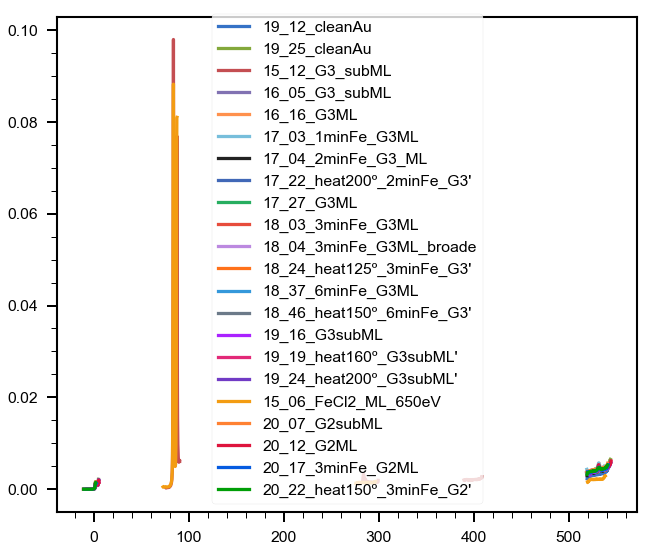

In [73]:
plotXpsRegion(region, print_color=True)
# plt.gca().set(xlim=(-1, 1), ylim=(0, 0.002))
plt.legend()

## C 1s

In [118]:
region = f['XPS']['C 1s']

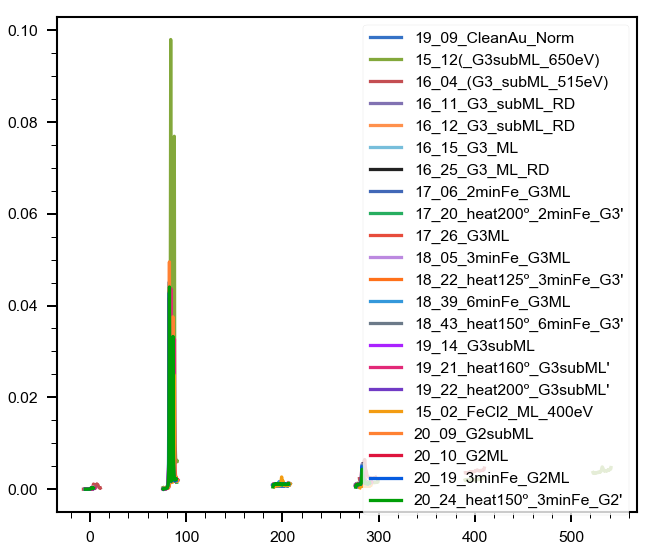

In [119]:
plotXpsRegion(region)
# plt.gca().set(xlim=(-1, 1), ylim=(0, 0.002))
plt.legend()

[(0, 0.0005), (-1, 20)]

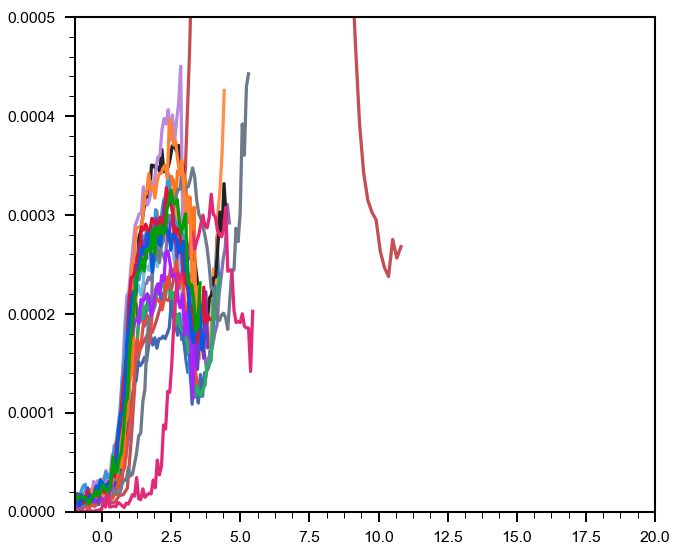

In [120]:
plotXpsRegion(region)
plt.gca().set(xlim=(-1, 20), ylim=(0, 5e-4))
# plt.legend()

19_11_202109_CleanAu_Norm -0.6274012036680089
16_11_202104_(G3_subML_515eV) -1.0626912636122003
16_11_202111_G3_subML_RD -0.7797072558953021
16_11_202112_G3_subML_RD -0.8167450142941454
16_11_202115_G3_ML -0.491184725764823
16_11_202125_G3_ML_RD -0.6587975025409261
17_11_202106_2minFe_G3ML -0.779966748258404
b'17_11_202120_heat200\xba_2minFe_G3' -0.6434333832840844
17_11_202126_G3ML -0.8958303857981071
18_11_202105_3minFe_G3ML -0.5154365969879915
b'18_11_202122_heat125\xba_3minFe_G3' -0.8495052742125432
18_11_202139_6minFe_G3ML -0.43479572907183994
b'18_11_202143_heat150\xba_6minFe_G3' -1.319369738327298
19_11_202114_G3subML -0.7292782575170376
b'19_11_202121_heat160\xba_G3subML' -2.22112218085806
b'19_11_202122_heat200\xba_G3subML' -0.600125854064314
20_11_202109_G2subML -0.7086895107637998
20_11_202110_G2ML -0.5264090782923738
20_11_202119_3minFe_G2ML -0.6077836412330361
b'20_11_202124_heat150\xba_3minFe_G2' -0.3917680805868256
192


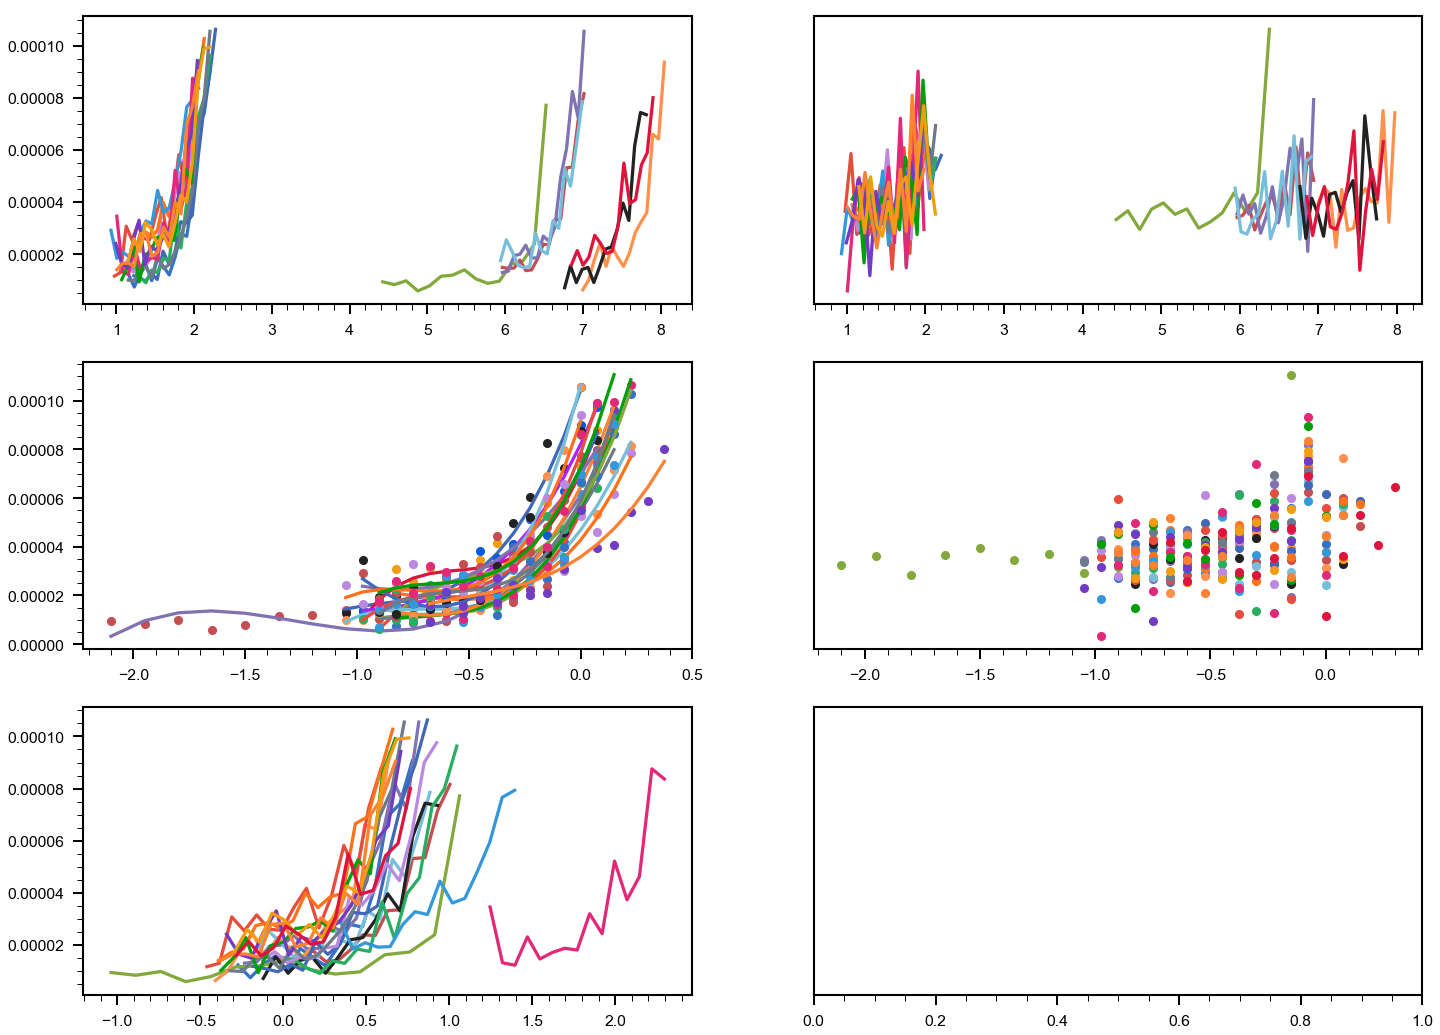

In [830]:
ebavg, cnavg = plotFermi(region, fermiCut=1.08e-4, width=15, b0=2.2086417921219144e-05, inplace=True)
# plt.gca().legend()

### Avg VB at C 1s 

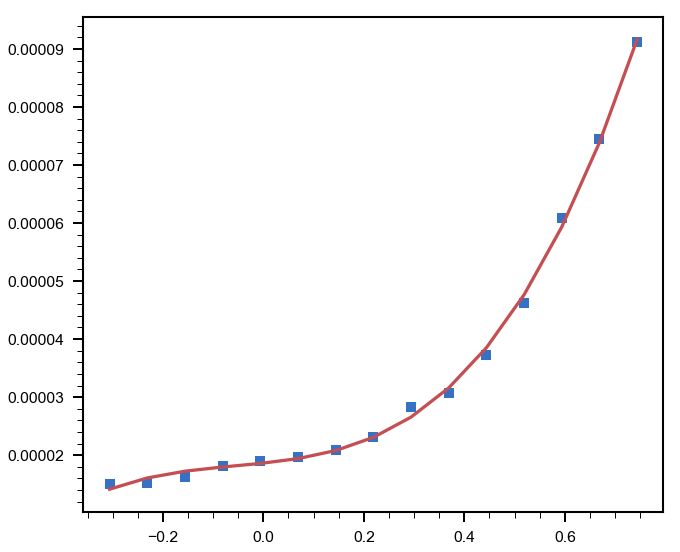

In [772]:
plt.plot(ebavg, cnavg, 's')
mxc, mnc = np.max(cnavg), np.min(cnavg)

mod = PolynomialModel(prefix='', degree=3)

pars = mod.guess(cnavg, x=ebavg)
#     pars[prefix+'sigma'].set(value=1) # Usually guessed wrong anyway
fitv = mod.fit(cnavg, pars, x=ebavg)
plt.plot(ebavg, fitv.best_fit, 'r')
fitv

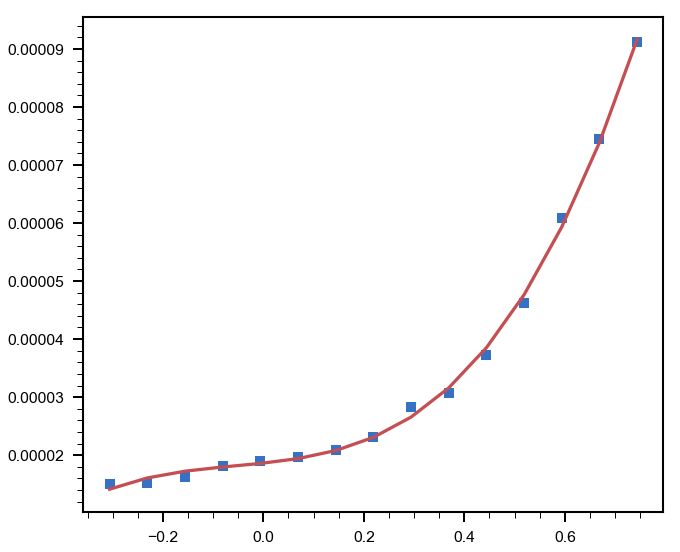

In [773]:
plt.plot(ebavg, cnavg, 's')

modm = ExpressionModel(' c0 + c1 * (x-x0) + c2* (x-x0)**2 + c3 * (x-x0)**3 ')
# mod = PolynomialModel(prefix='v0_', degree=3)

# for i in range(4):
#     modm.set_param_hint('c'+str(i), value=fitv.best_values['c'+str(i)])

x0 = -1
c = [fitv.best_values['c'+str(i)] for i in range(4)]
modm.set_param_hint('x0', value=x0)
modm.set_param_hint('c3', value=c[3])
modm.set_param_hint('c2', value=c[2]+3*x0*c[3])
modm.set_param_hint('c1', value=c[1]+2*c[2]*x0+3*c[3]*x0**2)
modm.set_param_hint('c0', value=c[0]+c[1]*x0+c[3]*x0**3+c[2]*x0**2)

parsm = modm.make_params()
fitm = modm.fit(cnavg, parsm, x=ebavg)
plt.plot(ebavg, fitm.best_fit, 'r')
fitm

In [776]:
b0 = fitv.best_values['c2']
b0

2.2086417921219144e-05

### Plot after shift

[(0, 0.0005), (20, -1)]

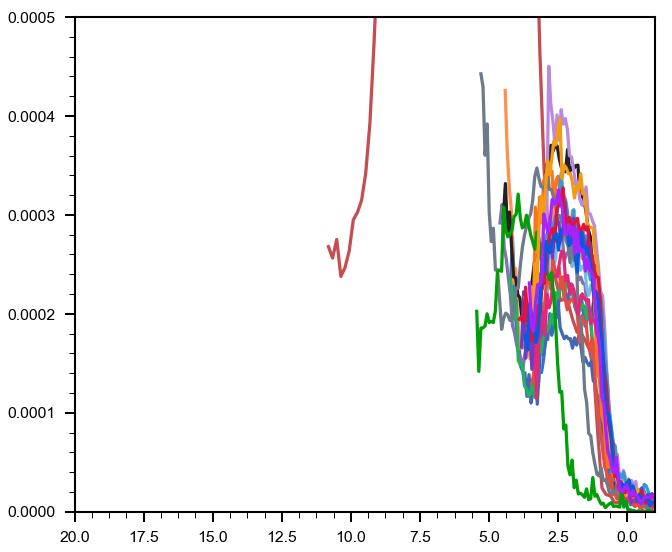

In [831]:
plotXpsRegion(region)
plt.gca().set(xlim=(20, -1), ylim=(0, 5e-4))
# plt.legend()

[(0, 0.006), (292, 279)]

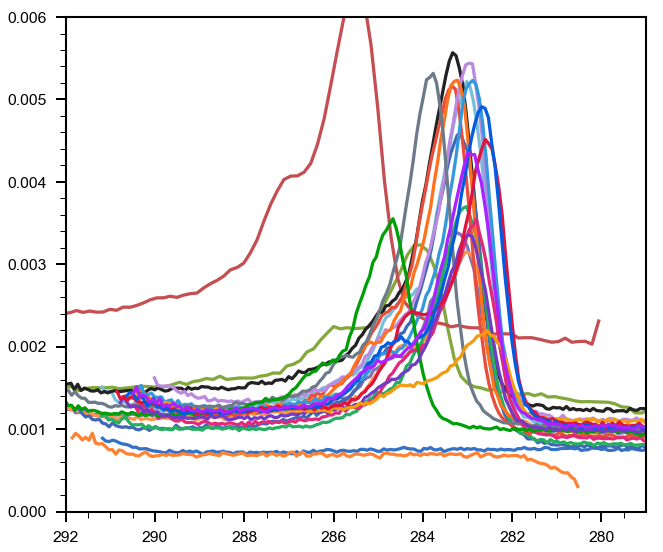

In [832]:
plotXpsRegion(region)
plt.gca().set(xlim=(292, 279), ylim=(0, 6e-3))
# plt.legend()

### Script igor

In [121]:
AppendToGraph(region)

AppendToGraph ':'XPS':'C 1s':'CleanAu':'19_11_202109_CleanAu_Norm':wCnts_19_11_202109 vs ':'XPS':'C 1s':'CleanAu':'19_11_202109_CleanAu_Norm':wEbin_19_11_202109
AppendToGraph ':'XPS':'C 1s':'FBI-G3 1st evap (subML)':'15_11_202112(_G3subML_650eV)':wCnts_15_11_202112 vs ':'XPS':'C 1s':'FBI-G3 1st evap (subML)':'15_11_202112(_G3subML_650eV)':wEbin_15_11_202112
AppendToGraph ':'XPS':'C 1s':'FBI-G3 2nd evap':'16_11_202104_(G3_subML_515eV)':wCnts_16_11_202104 vs ':'XPS':'C 1s':'FBI-G3 2nd evap':'16_11_202104_(G3_subML_515eV)':wEbin_16_11_202104
AppendToGraph ':'XPS':'C 1s':'FBI-G3 2nd evap':'16_11_202111_G3_subML_RD':wCnts_16_11_202111 vs ':'XPS':'C 1s':'FBI-G3 2nd evap':'16_11_202111_G3_subML_RD':wEbin_16_11_202111
AppendToGraph ':'XPS':'C 1s':'FBI-G3 2nd evap':'16_11_202112_G3_subML_RD':wCnts_16_11_202112 vs ':'XPS':'C 1s':'FBI-G3 2nd evap':'16_11_202112_G3_subML_RD':wEbin_16_11_202112
AppendToGraph ':'XPS':'C 1s':'FBI-G3 2nd evap':'16_11_202115_G3_ML':wCnts_16_11_202115 vs ':'XPS':'C 1s':

In [122]:
ModifyGraph_lSize(region)

ModifyGraph lSize(wCnts_19_11_202109)=2
ModifyGraph lSize(wCnts_15_11_202112)=2
ModifyGraph lSize(wCnts_16_11_202104)=2
ModifyGraph lSize(wCnts_16_11_202111)=2
ModifyGraph lSize(wCnts_16_11_202112)=2
ModifyGraph lSize(wCnts_16_11_202115)=2
ModifyGraph lSize(wCnts_16_11_202125)=2
ModifyGraph lSize(wCnts_17_11_202106)=2
ModifyGraph lSize(wCnts_17_11_202120)=2
ModifyGraph lSize(wCnts_17_11_202126)=2
ModifyGraph lSize(wCnts_18_11_202105)=2
ModifyGraph lSize(wCnts_18_11_202122)=2
ModifyGraph lSize(wCnts_18_11_202139)=2
ModifyGraph lSize(wCnts_18_11_202143)=2
ModifyGraph lSize(wCnts_19_11_202114)=2
ModifyGraph lSize(wCnts_19_11_202121)=2
ModifyGraph lSize(wCnts_19_11_202122)=2
ModifyGraph lSize(wCnts_15_11_202102)=2
ModifyGraph lSize(wCnts_20_11_202109)=2
ModifyGraph lSize(wCnts_20_11_202110)=2
ModifyGraph lSize(wCnts_20_11_202119)=2
ModifyGraph lSize(wCnts_20_11_202124)=2


rgb( wCnts_19_11_202109 )= (13621, 29298, 50886)
rgb( wCnts_15_11_202112 )= (33667, 43176, 15163)
rgb( wCnts_16_11_202104 )= (50372, 20046, 21074)
rgb( wCnts_16_11_202111 )= (33153, 29298, 45746)
rgb( wCnts_16_11_202112 )= (65535, 37265, 19789)
rgb( wCnts_16_11_202115 )= (30583, 48830, 56283)
rgb( wCnts_16_11_202125 )= (8738, 8738, 8738)
rgb( wCnts_17_11_202106 )= (16705, 26728, 47031)
rgb( wCnts_17_11_202120 )= (10023, 44718, 24672)
rgb( wCnts_17_11_202126 )= (59367, 19532, 15420)
rgb( wCnts_18_11_202105 )= (48316, 35209, 57568)
rgb( wCnts_18_11_202122 )= (65535, 29041, 6682)
rgb( wCnts_18_11_202139 )= (13364, 39064, 56283)
rgb( wCnts_18_11_202143 )= (27756, 31354, 35209)
rgb( wCnts_19_11_202114 )= (43690, 8738, 65535)
rgb( wCnts_19_11_202121 )= (58082, 10537, 30840)
rgb( wCnts_19_11_202122 )= (29041, 15163, 50629)
rgb( wCnts_15_11_202102 )= (62451, 40092, 4626)
rgb( wCnts_20_11_202109 )= (65535, 33153, 12850)
rgb( wCnts_20_11_202110 )= (57054, 5140, 15677)
rgb( wCnts_20_11_202119 )= 

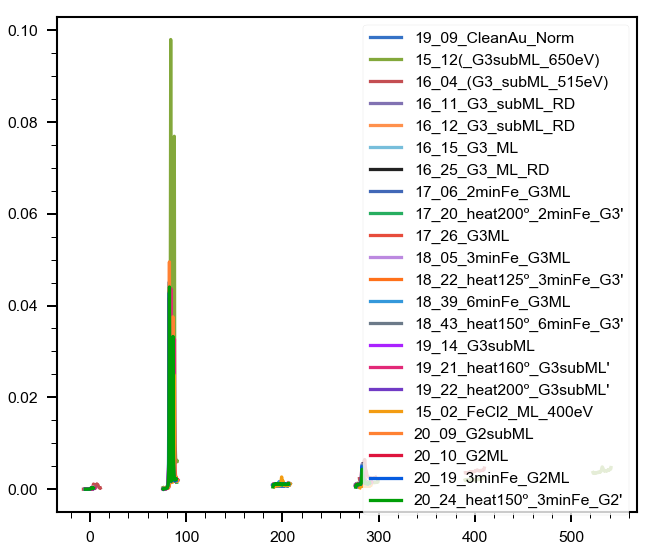

In [123]:
plotXpsRegion(region, print_color=True)
# plt.gca().set(xlim=(-1, 1), ylim=(0, 0.002))
plt.legend()

## Cl 2p

In [125]:
region = f['XPS']['Cl 2p']

### Script igor

In [126]:
AppendToGraph(region)

AppendToGraph ':'XPS':'Cl 2p':'FBI-G3 2nd evap':'17_11_202107_2minFe_G3ML_scan1':wCnts_17_11_202107 vs ':'XPS':'Cl 2p':'FBI-G3 2nd evap':'17_11_202107_2minFe_G3ML_scan1':wEbin_17_11_202107
AppendToGraph ':'XPS':'Cl 2p':'FBI-G3 2nd evap':'17_11_202108_2minFe_G3ML_scan2':wCnts_17_11_202108 vs ':'XPS':'Cl 2p':'FBI-G3 2nd evap':'17_11_202108_2minFe_G3ML_scan2':wEbin_17_11_202108
AppendToGraph ':'XPS':'Cl 2p':'FBI-G3 2nd evap':'17_11_202120_heat200º_2minFe_G3'':wCnts_17_11_202120 vs ':'XPS':'Cl 2p':'FBI-G3 2nd evap':'17_11_202120_heat200º_2minFe_G3'':wEbin_17_11_202120
AppendToGraph ':'XPS':'Cl 2p':'FBI-G3 3rd evap':'18_11_202117_3minFe_G3ML_RD':wCnts_18_11_202117 vs ':'XPS':'Cl 2p':'FBI-G3 3rd evap':'18_11_202117_3minFe_G3ML_RD':wEbin_18_11_202117
AppendToGraph ':'XPS':'Cl 2p':'FBI-G3 3rd evap':'18_11_202118_3minFe_G3ML_Vb':wCnts_18_11_202118 vs ':'XPS':'Cl 2p':'FBI-G3 3rd evap':'18_11_202118_3minFe_G3ML_Vb':wEbin_18_11_202118
AppendToGraph ':'XPS':'Cl 2p':'FBI-G3 3rd evap':'18_11_202119_3

In [127]:
ModifyGraph_lSize(region)

ModifyGraph lSize(wCnts_17_11_202107)=2
ModifyGraph lSize(wCnts_17_11_202108)=2
ModifyGraph lSize(wCnts_17_11_202120)=2
ModifyGraph lSize(wCnts_18_11_202117)=2
ModifyGraph lSize(wCnts_18_11_202118)=2
ModifyGraph lSize(wCnts_18_11_202119)=2
ModifyGraph lSize(wCnts_18_11_202120)=2
ModifyGraph lSize(wCnts_18_11_202141)=2
ModifyGraph lSize(wCnts_15_11_202110)=2
ModifyGraph lSize(wCnts_20_11_202103)=2
ModifyGraph lSize(wCnts_20_11_202105)=2


rgb( wCnts_17_11_202107 )= (13621, 29298, 50886)
rgb( wCnts_17_11_202108 )= (33667, 43176, 15163)
rgb( wCnts_17_11_202120 )= (50372, 20046, 21074)
rgb( wCnts_18_11_202117 )= (33153, 29298, 45746)
rgb( wCnts_18_11_202118 )= (65535, 37265, 19789)
rgb( wCnts_18_11_202119 )= (30583, 48830, 56283)
rgb( wCnts_18_11_202120 )= (8738, 8738, 8738)
rgb( wCnts_18_11_202141 )= (16705, 26728, 47031)
rgb( wCnts_15_11_202110 )= (10023, 44718, 24672)
rgb( wCnts_20_11_202103 )= (59367, 19532, 15420)
rgb( wCnts_20_11_202105 )= (48316, 35209, 57568)


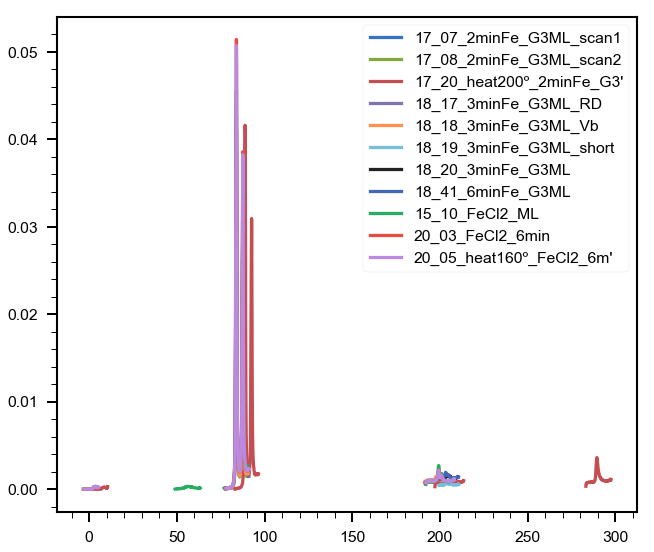

In [128]:
plotXpsRegion(region, print_color=True)
# plt.gca().set(xlim=(-1, 1), ylim=(0, 0.002))
plt.legend()

## N 1s (unfinished)

In [834]:
region = f['XPS']['N 1s']

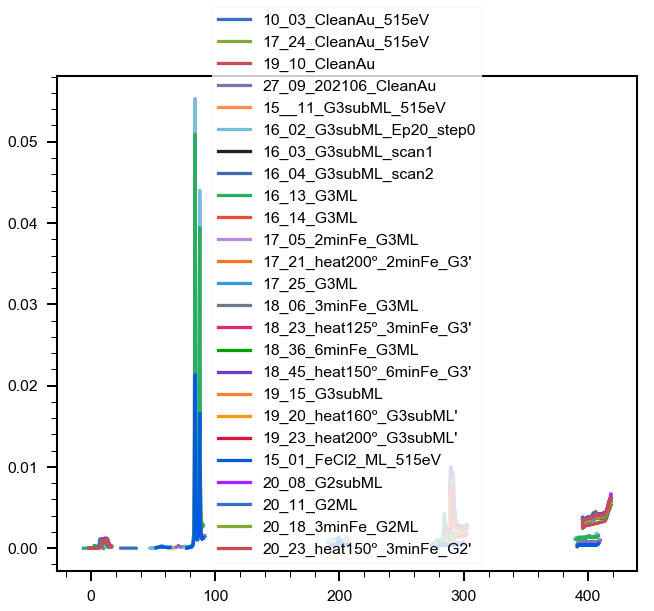

In [835]:
plotXpsRegion(region)
# plt.gca().set(xlim=(-1, 1), ylim=(0, 0.002))
plt.legend()

[(0, 0.0005), (-1, 20)]

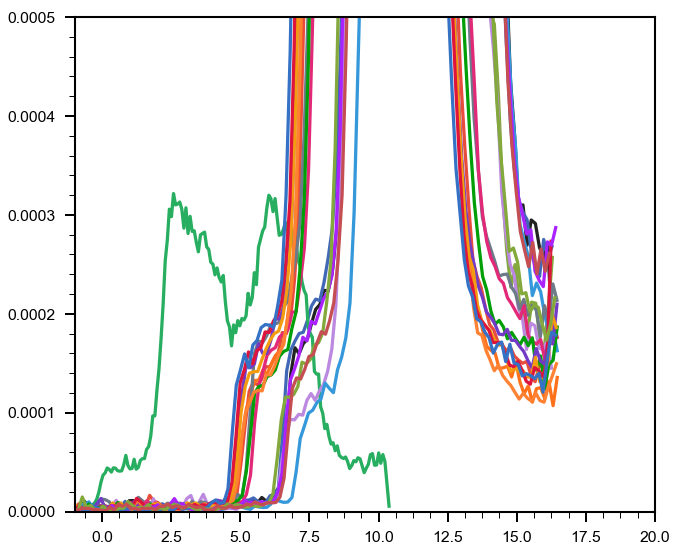

In [836]:
plotXpsRegion(region)
plt.gca().set(xlim=(-1, 20), ylim=(0, 5e-4))
# plt.legend()

10_11_202103_CleanAu_515eV -0.4365371511110587
15_11_2021_11_G3subML_515eV 0.45935719444753936
16_11_202102_G3subML_Ep20_step0 -0.8232716752854223
16_11_202103_G3subML_scan1 -1.1327316693199045
16_11_202104_G3subML_scan2 -1.0626912636122003
16_11_202113_G3ML -0.2801059437404232
16_11_202114_G3ML -1.1289334584826074
17_11_202105_2minFe_G3ML -0.20485225403113572
b'17_11_202121_heat200\xba_2minFe_G3' -1.098128684439268
17_11_202125_G3ML -0.9842755891503066
18_11_202106_3minFe_G3ML -1.1427470661893215
b'18_11_202123_heat125\xba_3minFe_G3' -1.103892204028336
18_11_202136_6minFe_G3ML -1.1063789511238138
b'18_11_202145_heat150\xba_6minFe_G3' -1.068041690590314
19_11_202115_G3subML -1.0748290917626613
b'19_11_202120_heat160\xba_G3subML' -1.0115829431076844
b'19_11_202123_heat200\xba_G3subML' -1.0742159769830797
20_11_202108_G2subML -1.1227439817941165
20_11_202111_G2ML -1.09280690499705
20_11_202118_3minFe_G2ML -1.1536570945996378
b'20_11_202123_heat150\xba_3minFe_G2' -1.0943729849184132
152


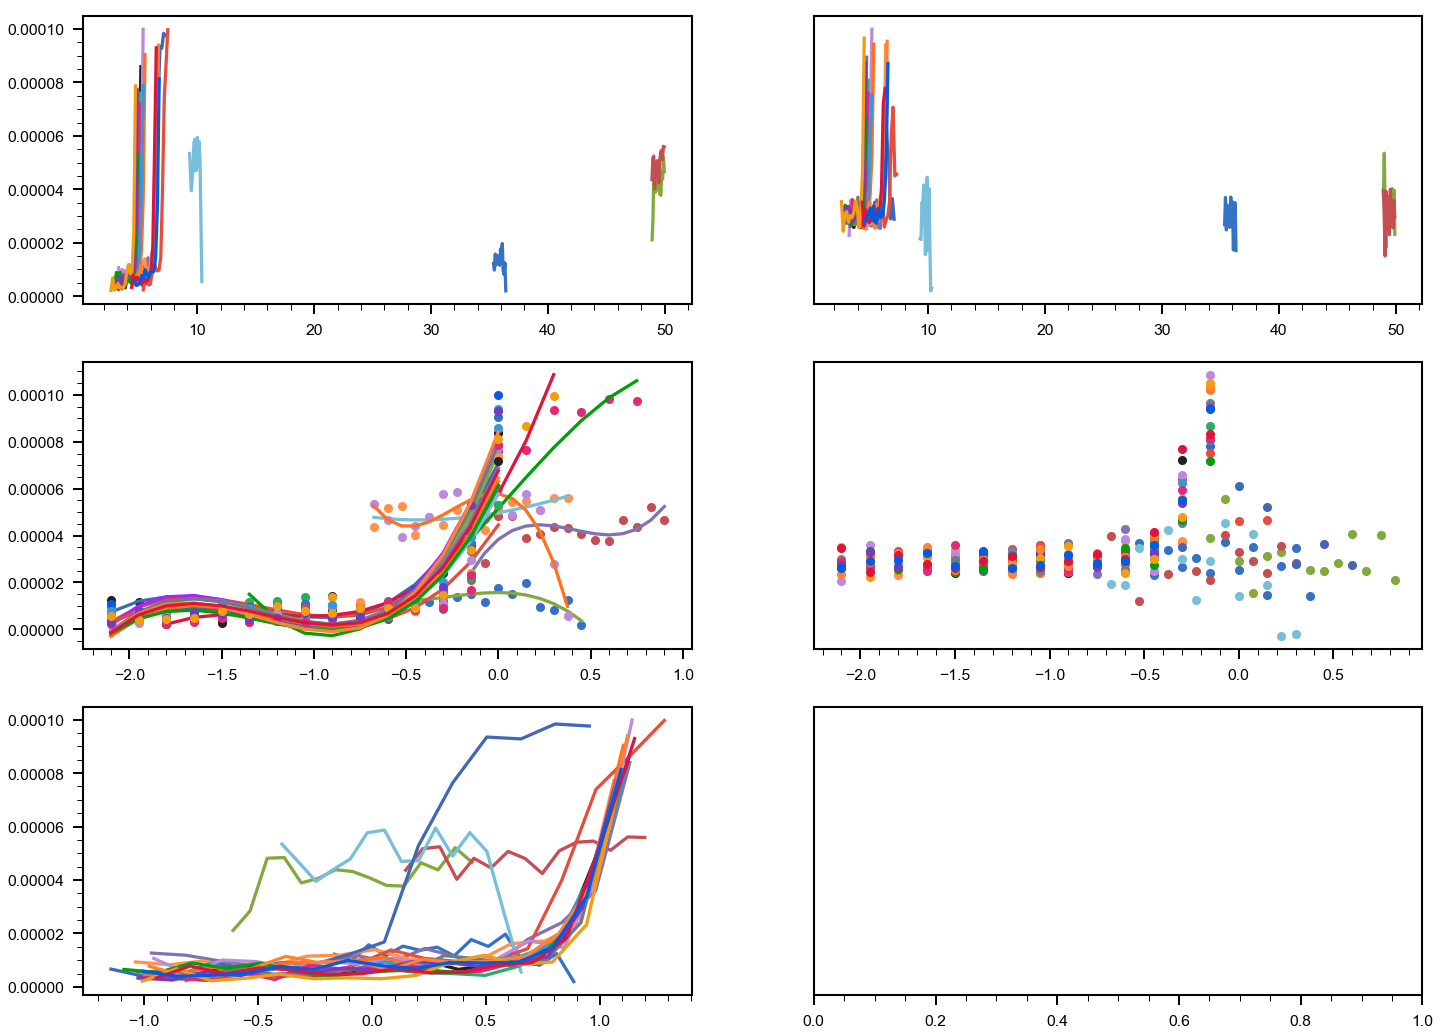

In [837]:
ebavg, cnavg = plotFermi(region, fermiCut=1.0e-4, width=15, b0=2.2086417921219144e-05, inplace=False)
# plt.gca().legend()

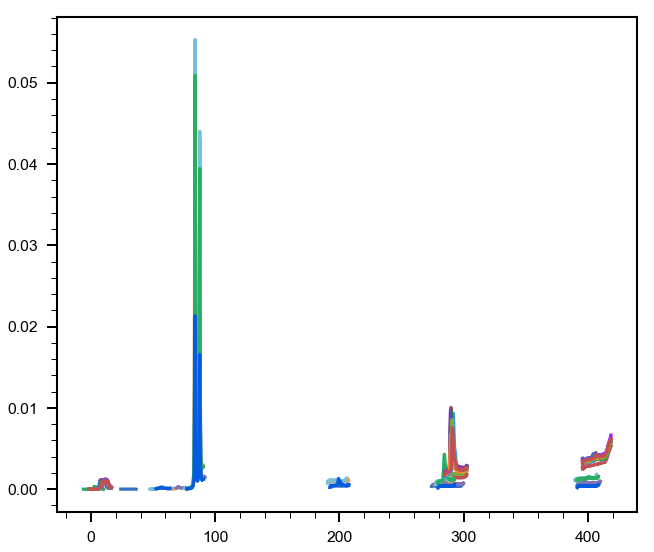

In [838]:
plotXpsRegion(region)
# plt.gca().set(xlim=(-1, 20), ylim=(0, 5e-4))
# plt.legend()

## Fe 2p (unfinished)

In [199]:
region = f['XPS']['Fe 2p']

### Script igor

In [78]:
exps = getExps(region)
flat_exps = []
for k, v in exps.items():
    for xp in v:
        wn = list(region[k][xp])
        waves = region[k][xp]
        if type(xp) == bytes: 
            label = str(waves.name)
            label = label.replace("b'", '')
            label = label.replace('\\xba', 'º')
        else: label = waves.name
#         print(label)
        print('AppendToGraph '+label.replace('/', "':'")+':' + wn[0] + ' vs ' + label.replace('/', "':'") + ':'+wn[1])

AppendToGraph ':'XPS':'Fe 2p':'Clean_Au':'15_11_202114_cleanAu_870eV:wCnts_15_11_202114 vs ':'XPS':'Fe 2p':'Clean_Au':'15_11_202114_cleanAu_870eV:wEbin_15_11_202114
AppendToGraph ':'XPS':'Fe 2p':'Clean_Au':'16_11_202100_cleanAu_870eV:wCnts_16_11_202100 vs ':'XPS':'Fe 2p':'Clean_Au':'16_11_202100_cleanAu_870eV:wEbin_16_11_202100
AppendToGraph ':'XPS':'Fe 2p':'Clean_Au':'16_11_202101_cleanAu_870eV:wCnts_16_11_202101 vs ':'XPS':'Fe 2p':'Clean_Au':'16_11_202101_cleanAu_870eV:wEbin_16_11_202101
AppendToGraph ':'XPS':'Fe 2p':'Clean_Au':'19_11_202111_cleanAu_840eV:wCnts_19_11_202111 vs ':'XPS':'Fe 2p':'Clean_Au':'19_11_202111_cleanAu_840eV:wEbin_19_11_202111
AppendToGraph ':'XPS':'Fe 2p':'FBI-G3 1st evap (subML)':'15_11_2021_13_G3subML_870eV:wCnts_15_11_202113 vs ':'XPS':'Fe 2p':'FBI-G3 1st evap (subML)':'15_11_2021_13_G3subML_870eV:wEbin_15_11_202113
AppendToGraph ':'XPS':'Fe 2p':'FBI-G3 2nd evap':'16_11_202127_G3_ML_RD_840eV:wCnts_16_11_202127 vs ':'XPS':'Fe 2p':'FBI-G3 2nd evap':'16_11_202

In [200]:
exps = getExps(region)
flat_exps = []
for k, v in exps.items():
    for xp in v:
        wn = list(region[k][xp])
        waves = region[k][xp]
        if type(xp) == bytes: 
            label = str(waves.name)
            label = label.replace("b'", '')
            label = label.replace('\\xba', 'º')
        else: label = waves.name
#         print(label)
        label = label.replace('/', "':'").replace("':'NEXAFS'", "root:NEXAFS")
        print('AlignFolder( "'+label.replace('/', "':'")+')')

AlignFolder( "':'XPS':'Fe 2p':'Clean_Au':'15_11_202114_cleanAu_870eV)
AlignFolder( "':'XPS':'Fe 2p':'Clean_Au':'16_11_202100_cleanAu_870eV)
AlignFolder( "':'XPS':'Fe 2p':'Clean_Au':'16_11_202101_cleanAu_870eV)
AlignFolder( "':'XPS':'Fe 2p':'Clean_Au':'19_11_202111_cleanAu_840eV)
AlignFolder( "':'XPS':'Fe 2p':'FBI-G3 1st evap (subML)':'15_11_2021_13_G3subML_870eV)
AlignFolder( "':'XPS':'Fe 2p':'FBI-G3 2nd evap':'16_11_202127_G3_ML_RD_840eV)
AlignFolder( "':'XPS':'Fe 2p':'FBI-G3 2nd evap':'17_11_202101_1minFe_G3_ML_RD)
AlignFolder( "':'XPS':'Fe 2p':'FBI-G3 2nd evap':'17_11_202102_1minFe_G3_ML)
AlignFolder( "':'XPS':'Fe 2p':'FBI-G3 2nd evap':'17_11_202110_2minFe_G3ML)
AlignFolder( "':'XPS':'Fe 2p':'FBI-G3 2nd evap':'17_11_202123_heat200º_2minFe_G3')
AlignFolder( "':'XPS':'Fe 2p':'FBI-G3 3rd evap':'18_11_202102_3minFe_G3ML)
AlignFolder( "':'XPS':'Fe 2p':'FBI-G3 3rd evap':'18_11_202107_3minFe_G3ML_broade)
AlignFolder( "':'XPS':'Fe 2p':'FBI-G3 3rd evap':'18_11_202125_heat125º_3minFe_G3')
Ali

In [79]:
exps = getExps(region)
flat_exps = []
for k, v in exps.items():
    for xp in v:
        wn = list(region[k][xp])
        waves = region[k][xp]
        if type(xp) == bytes: 
            label = str(waves.name)
            label = label.replace("b'", '')
            label = label.replace('\\xba', 'º')
        else: label = waves.name
#         print(label)
        print('ModifyGraph lSize('+ wn[0] + ')=2')

ModifyGraph lSize(wCnts_15_11_202114)=2
ModifyGraph lSize(wCnts_16_11_202100)=2
ModifyGraph lSize(wCnts_16_11_202101)=2
ModifyGraph lSize(wCnts_19_11_202111)=2
ModifyGraph lSize(wCnts_15_11_202113)=2
ModifyGraph lSize(wCnts_16_11_202127)=2
ModifyGraph lSize(wCnts_17_11_202101)=2
ModifyGraph lSize(wCnts_17_11_202102)=2
ModifyGraph lSize(wCnts_17_11_202110)=2
ModifyGraph lSize(wCnts_17_11_202123)=2
ModifyGraph lSize(wCnts_18_11_202102)=2
ModifyGraph lSize(wCnts_18_11_202107)=2
ModifyGraph lSize(wCnts_18_11_202125)=2
ModifyGraph lSize(wCnts_18_11_202138)=2
ModifyGraph lSize(wCnts_19_11_202100)=2
ModifyGraph lSize(wCnts_15_11_202104)=2
ModifyGraph lSize(wCnts_15_11_202105)=2
ModifyGraph lSize(wCnts_20_11_202102)=2
ModifyGraph lSize(wCnts_20_11_202106)=2
ModifyGraph lSize(wCnts_20_11_202116)=2
ModifyGraph lSize(wCnts_20_11_202121)=2


rgb( wCnts_15_11_202114 )= (13621, 29298, 50886)
rgb( wCnts_16_11_202100 )= (33667, 43176, 15163)
rgb( wCnts_16_11_202101 )= (50372, 20046, 21074)
rgb( wCnts_19_11_202111 )= (33153, 29298, 45746)
rgb( wCnts_15_11_202113 )= (65535, 37265, 19789)
rgb( wCnts_16_11_202127 )= (30583, 48830, 56283)
rgb( wCnts_17_11_202101 )= (8738, 8738, 8738)
rgb( wCnts_17_11_202102 )= (16705, 26728, 47031)
rgb( wCnts_17_11_202110 )= (10023, 44718, 24672)
rgb( wCnts_17_11_202123 )= (59367, 19532, 15420)
rgb( wCnts_18_11_202102 )= (48316, 35209, 57568)
rgb( wCnts_18_11_202107 )= (65535, 29041, 6682)
rgb( wCnts_18_11_202125 )= (13364, 39064, 56283)
rgb( wCnts_18_11_202138 )= (27756, 31354, 35209)
rgb( wCnts_19_11_202100 )= (43690, 8738, 65535)
rgb( wCnts_15_11_202104 )= (58082, 10537, 30840)
rgb( wCnts_15_11_202105 )= (29041, 15163, 50629)
rgb( wCnts_20_11_202102 )= (62451, 40092, 4626)
rgb( wCnts_20_11_202106 )= (65535, 33153, 12850)
rgb( wCnts_20_11_202116 )= (57054, 5140, 15677)
rgb( wCnts_20_11_202121 )= 

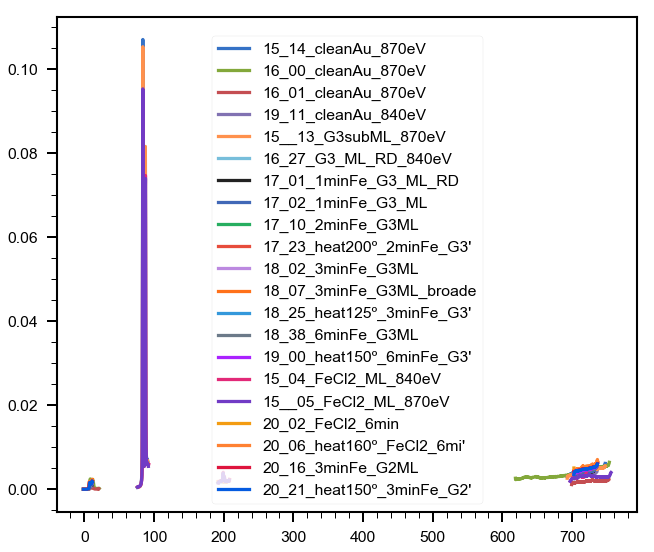

In [80]:
plotXpsRegion(region, print_color=True)
# plt.gca().set(xlim=(-1, 1), ylim=(0, 0.002))
plt.legend()

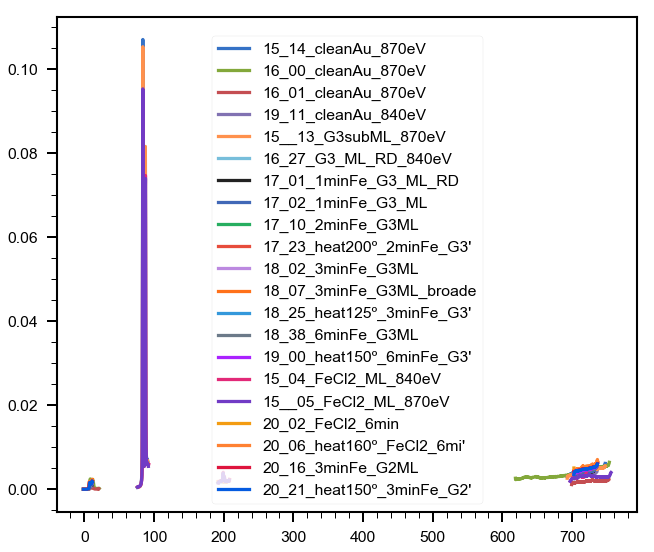

In [76]:
plotXpsRegion(region)
# plt.gca().set(xlim=(-1, 1), ylim=(0, 0.002))
plt.legend()

[(0, 0.0005), (-1, 20)]

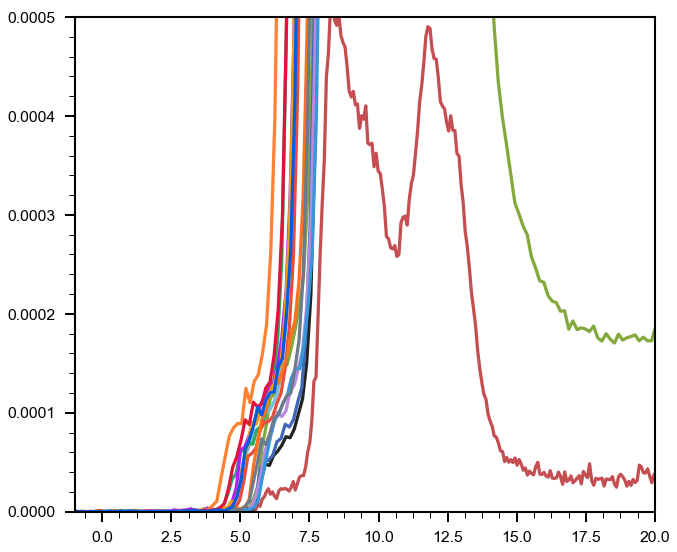

In [77]:
plotXpsRegion(region)
plt.gca().set(xlim=(-1, 20), ylim=(0, 5e-4))
# plt.legend()

16_11_202100_cleanAu_870eV -1.0487981813176424
16_11_202101_cleanAu_870eV -0.816180369186827
16_11_202127_G3_ML_RD_840eV -0.11216406980570492
17_11_202101_1minFe_G3_ML_RD -0.22999763332755374
17_11_202102_1minFe_G3_ML -0.0949397899177047
17_11_202110_2minFe_G3ML -0.40042835875664984
b'17_11_202123_heat200\xba_2minFe_G3' -0.19929637273336134
18_11_202102_3minFe_G3ML -0.17606412044251948
18_11_202107_3minFe_G3ML_broade -0.9196192533416432
b'18_11_202125_heat125\xba_3minFe_G3' -1.2382122364265737
18_11_202138_6minFe_G3ML -0.3545327266927456
b'19_11_202100_heat150\xba_6minFe_G3' 0.3925211800199017
20_11_202102_FeCl2_6min -1.1806652892580993
b'20_11_202106_heat160\xba_FeCl2_6mi' -0.09301310902960318
20_11_202116_3minFe_G2ML 1.3706951295030403
b'20_11_202121_heat150\xba_3minFe_G2' 0.047690174666567005
225


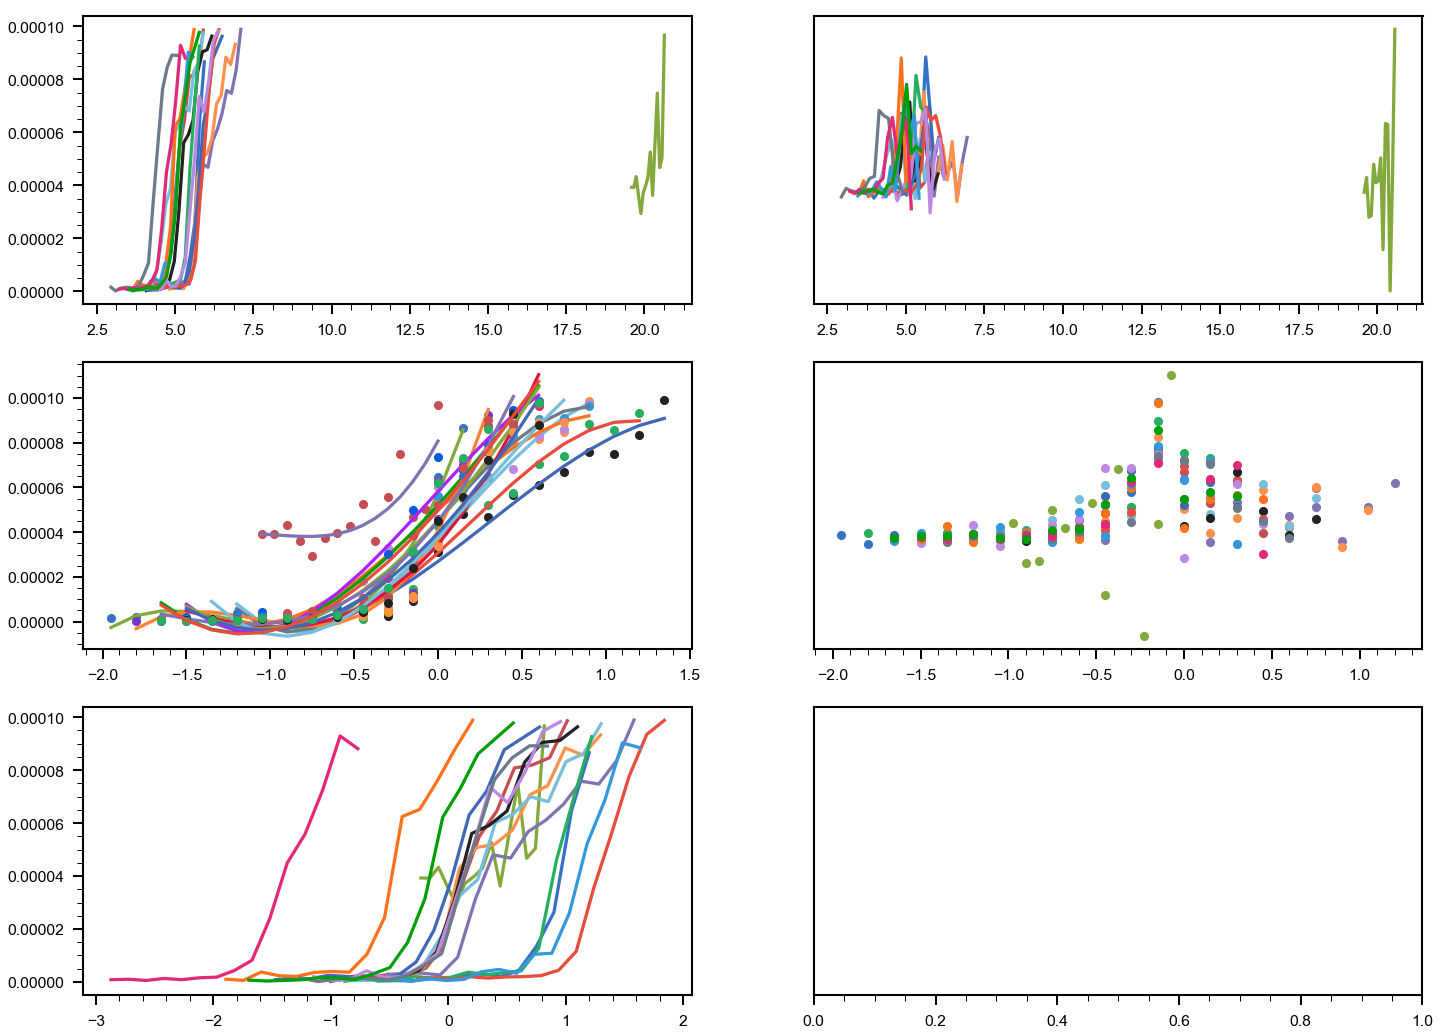

In [842]:
ebavg, cnavg = plotFermi(region, fermiCut=1.0e-4, width=15, b0=2.2086417921219144e-05, inplace=False)
# plt.gca().legend()

In [ ]:
plotXpsRegion(region)
# plt.gca().set(xlim=(-1, 20), ylim=(0, 5e-4))
# plt.legend()

# TXPS

## Cl 2p 125ºC

In [5]:
list(f['TXPS']['18_11_202121_Cl2p_3minFe_G3ML'])

['CH7',
 'Temp',
 'avg_ch3',
 'avg_ch4',
 'avg_drain',
 'mRPESraw',
 'wEBinding',
 'wEPhoton',
 'wEkinetic',
 'wI0']

In [6]:
temp = f['TXPS']['18_11_202121_Cl2p_3minFe_G3ML']['Temp'][1:]
ebin = f['TXPS']['18_11_202121_Cl2p_3minFe_G3ML']['wEBinding'][1:]
data = f['TXPS']['18_11_202121_Cl2p_3minFe_G3ML']['mRPESraw'][:]
len(temp), temp, len(ebin), ebin, data.shape, data

(18, array([ 39.9,  43.6,  48.7,  53.7,  58.8,  63.9,  68.8,  74.4,  79.6,
         84.2,  89.5,  94.5,  99.5, 103.3, 108.7, 113.6, 118.4, 123.4],
       dtype=float32), 72, array([210.34117, 210.19118, 210.04118, 209.89117, 209.74118, 209.59117,
        209.44118, 209.29118, 209.14117, 208.99118, 208.84117, 208.69118,
        208.54118, 208.39117, 208.24118, 208.09117, 207.94118, 207.79118,
        207.64117, 207.49118, 207.34117, 207.19118, 207.04118, 206.89117,
        206.74118, 206.59117, 206.44118, 206.29118, 206.14117, 205.99118,
        205.84117, 205.69118, 205.54118, 205.39117, 205.24118, 205.09117,
        204.94118, 204.79118, 204.64117, 204.49118, 204.34117, 204.19118,
        204.04118, 203.89117, 203.74118, 203.59117, 203.44118, 203.29118,
        203.14117, 202.99118, 202.84117, 202.69118, 202.54118, 202.39117,
        202.24118, 202.09117, 201.94118, 201.79118, 201.64117, 201.49118,
        201.34117, 201.19118, 201.04118, 200.89117, 200.74118, 200.59117,
        200.4

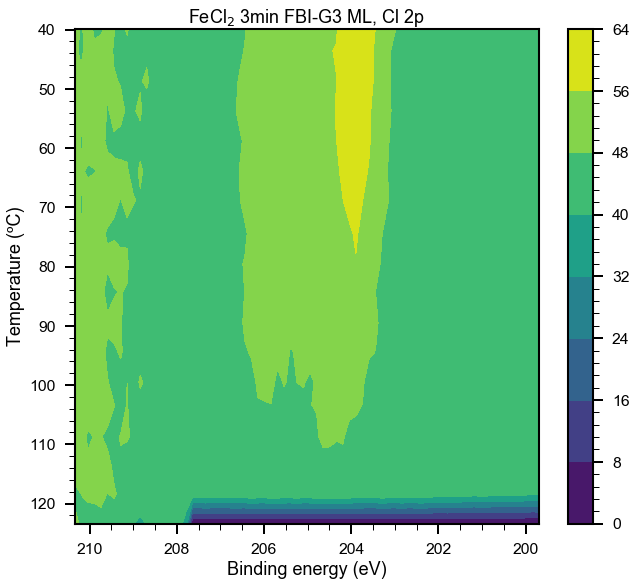

In [9]:
X, Y = np.meshgrid(ebin, temp)
fig = plt.figure()
mapp = plt.contourf(X, Y, data.T)
ax = plt.gca()

ax.invert_xaxis()
ax.invert_yaxis()
ax.set(xlabel='Binding energy (eV)', ylabel='Temperature (ºC)')
fig.colorbar(mapp)
plt.gca().set(title=('FeCl$_2$ 3min FBI-G3 ML, Cl 2p'))
plt.savefig('/Users/pabloherrero/sabat/SABAT/txps/FBIG3-FeCl2.png', dpi=400)

## Cl 2p 125ºC

In [10]:
list(f['TXPS'])

['18_11_202121_Cl2p_3minFe_G3ML',
 '18_11_202142_Cl2p_6minFe_G3ML',
 '20_11_202104']

In [11]:
exp = f['TXPS']['20_11_202104']
list(exp)

['CH7',
 'Temp',
 'V_Flag',
 'avg_ch3',
 'avg_ch4',
 'avg_drain',
 'mRPESraw',
 'wEBinding',
 'wEPhoton',
 'wEkinetic',
 'wI0']

In [12]:
temp = exp['Temp'][1:]
ebin = exp['wEBinding'][1:]
data = exp['mRPESraw'][:]
len(temp), temp, len(ebin), ebin, data.shape, data

(23, array([ 40.4,  44.3,  49.2,  54.6,  59.7,  64.7,  69.6,  74.8,  80. ,
         85.2,  90. ,  95.2, 100.4, 105.5, 110.5, 115.3, 120.4, 125.4,
        130.5, 135.4, 139.6, 144.7, 149.9], dtype=float32), 72, array([-189.65883, -189.80882, -189.95882, -190.10883, -190.25882,
        -190.40883, -190.55882, -190.70882, -190.85883, -191.00882,
        -191.15883, -191.30882, -191.45882, -191.60883, -191.75882,
        -191.90883, -192.05882, -192.20882, -192.35883, -192.50882,
        -192.65883, -192.80882, -192.95882, -193.10883, -193.25882,
        -193.40883, -193.55882, -193.70882, -193.85883, -194.00882,
        -194.15883, -194.30882, -194.45882, -194.60883, -194.75882,
        -194.90883, -195.05882, -195.20882, -195.35883, -195.50882,
        -195.65883, -195.80882, -195.95882, -196.10883, -196.25882,
        -196.40883, -196.55882, -196.70882, -196.85883, -197.00882,
        -197.15883, -197.30882, -197.45882, -197.60883, -197.75882,
        -197.90883, -198.05882, -198.20882,

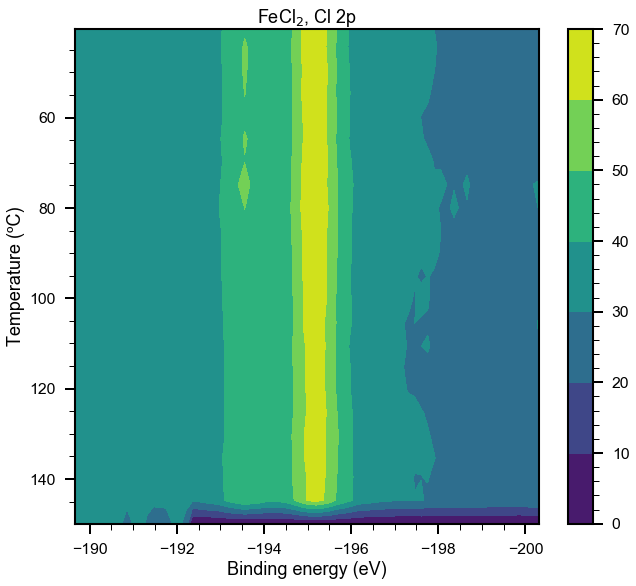

In [13]:
X, Y = np.meshgrid(ebin, temp)
fig = plt.figure()
mapp = plt.contourf(X, Y, data.T)
ax = plt.gca()
ax.invert_xaxis()
plt.gca().invert_yaxis()
ax.set(xlabel='Binding energy (eV)', ylabel='Temperature (ºC)')

fig.colorbar(mapp)
plt.gca().set(title=('FeCl$_2$, Cl 2p'))
plt.savefig('/Users/pabloherrero/sabat/SABAT/txps/FeCl2.png', dpi=400)

# Import data FeCl2

In [308]:
path = '/Users/pabloherrero/sabat/xps_spectra/ALOISA/'
files = glob.glob(path+'/**/*.txt')
files.sort()
files

['/Users/pabloherrero/sabat/xps_spectra/ALOISA/FeCl2/15_11_202105_clean_Au111_Fe2p_Cl2p_Au4f_870eV.txt',
 '/Users/pabloherrero/sabat/xps_spectra/ALOISA/FeCl2/16_11_202105_FBI_G3_N1s_C1s_Cl2p_Au4f_Au5p_515eV.txt',
 '/Users/pabloherrero/sabat/xps_spectra/ALOISA/FeCl2/20211115_FeCl2.txt']

In [251]:
def read_txt_dfx(path: str):
    dfte = pd.read_csv(path, sep='\s', na_values='sk', na_filter=False, skiprows=1, names=['energy', 'counts'])
    return dfte

def split_txt_dfx(dfte: pd.DataFrame, regions=list):
    regdels = [-1]
    for i, c in enumerate(dfte.counts):
        if np.isnan(c):
            regdels.append(i)
    regdels.append(-2)
    frames = []
    for j, re in enumerate(regdels):
        if j < len(regdels) -1:
            frames.append(dfte.iloc[re+1:regdels[j+1]])
            frames[-1].reset_index(inplace=True, drop=True)

    dfx = pd.concat(frames, axis=1)
    dfx.reset_index(inplace=True, drop=True)
    index2 = np.array(['energy', 'counts'])
    mi = pd.MultiIndex.from_product([regions, index2], names=['range', 'properties'])
    mi.to_frame()
    dfx.columns = mi
    return dfx

def aloisa_import_xps(path : str, regions: list, name : str = None, label : str = None, color: str = None) -> XPS_experiment:
    """Method to arrange a XPS_experiment data"""
    import re
    dfte = read_txt_dfx(path)
    dfx = split_txt_dfx(dfte, regions)

    relpath, filename = os.path.split(path)
    dir_name = os.path.split(relpath)[1]
    da = re.search('\d+_', filename).group(0).replace('/', '').replace('_', '')
    if da[:4] != '2020':
        date = re.sub('(\d{2})(\d{2})(\d{4})', r"\1.\2.\3", da, flags=re.DOTALL)
    else:
        date = re.sub('(\d{4})(\d{2})(\d{2})', r"\1.\2.\3", da, flags=re.DOTALL)

    other_meta = filename.replace(da, '')[1:].strip('.xy')
    if name == None: name = other_meta
    if label == None: label = da+'_'+other_meta

    return XPS_experiment(path = path, dfx = dfx, delimiters = None, color = color, name = name,
                          label = label, date = date, other_meta = other_meta, fit={}, area={})

In [317]:
regions = ['Fe_2p', 'Cl_2p', 'Au_4f']

xpFeCl2 = aloisa_import_xps(files[2], regions)

regions = ['N_1s', 'C_1s', 'Cl_2p', 'Au_4f', 'Au_5p']

xpCleanAu = aloisa_import_xps(files[0], regions)

regions = ['N_1s', 'C_1s', 'Cl_2p', 'Au_4f', 'Au_5p']

xpFBIG3_50min = aloisa_import_xps(files[1], regions)
xpFBIG3_50min = scale_dfx(xpFBIG3_50min, scale_factor=39.6/asf515['Au_4f'])
xpCleanAu = scale_dfx(xpCleanAu, scale_factor=46.4/asf870['Au_4f'])

In [159]:
xpFeCl2 = xp[2]

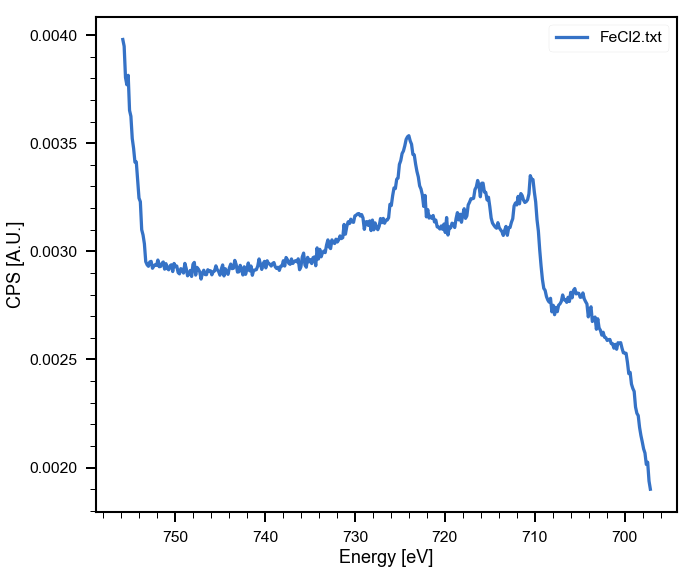

In [310]:
plot_region(xpFeCl2, 'Fe_2p')

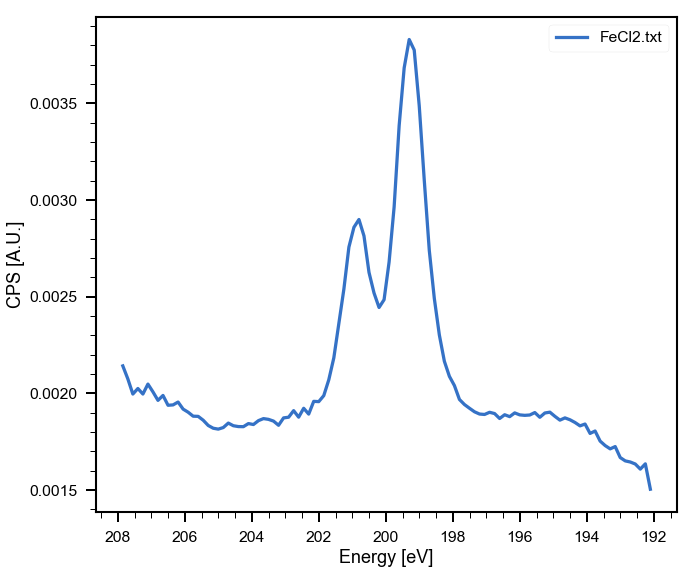

In [311]:
plot_region(xpFeCl2, 'Cl_2p')

In [319]:
trim_spectra(xpCleanAu, xpFBIG3_50min, 'Au_4f', inplace=True);

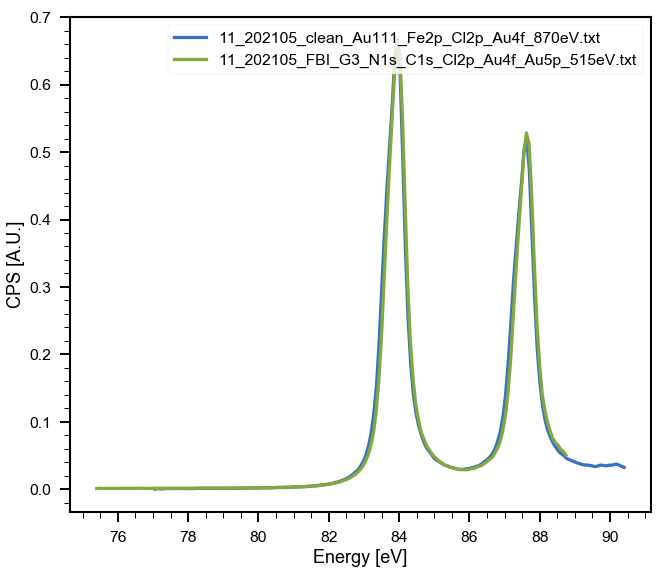

In [318]:
plot_region(xpCleanAu, 'Au_4f')
# plot_region(xpFeCl2, 'Au_4f')
plot_region(xpFBIG3_50min, 'Au_4f')

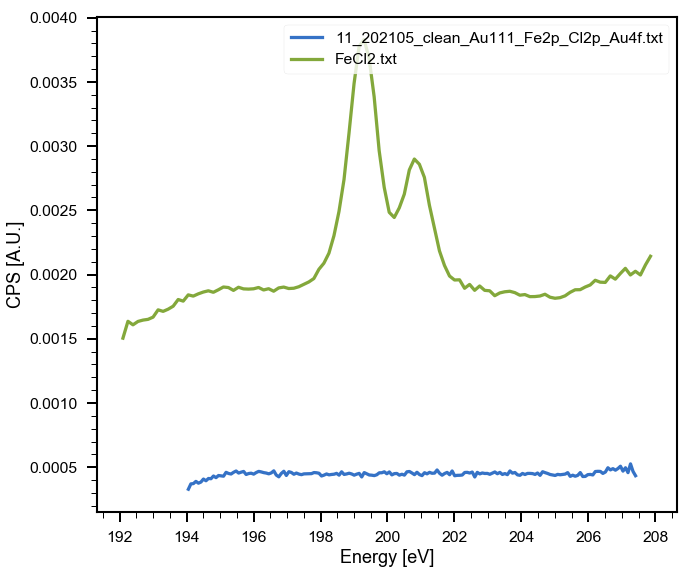

In [266]:
plot_region(xpCleanAu, 'Cl_2p')
plot_region(xpFeCl2, 'Cl_2p')

## Subtract bg

In [320]:
crop_spectrum(xpFeCl2, 'Fe_2p', edw=704, eup=750, inplace=True);
crop_spectrum(xpFeCl2, 'Cl_2p', edw=195, eup=205, inplace=True);

KeyError on  'Fe_2p'
KeyError on  'Fe_2p'
Max iterations exceeded, subtract ALS baseline


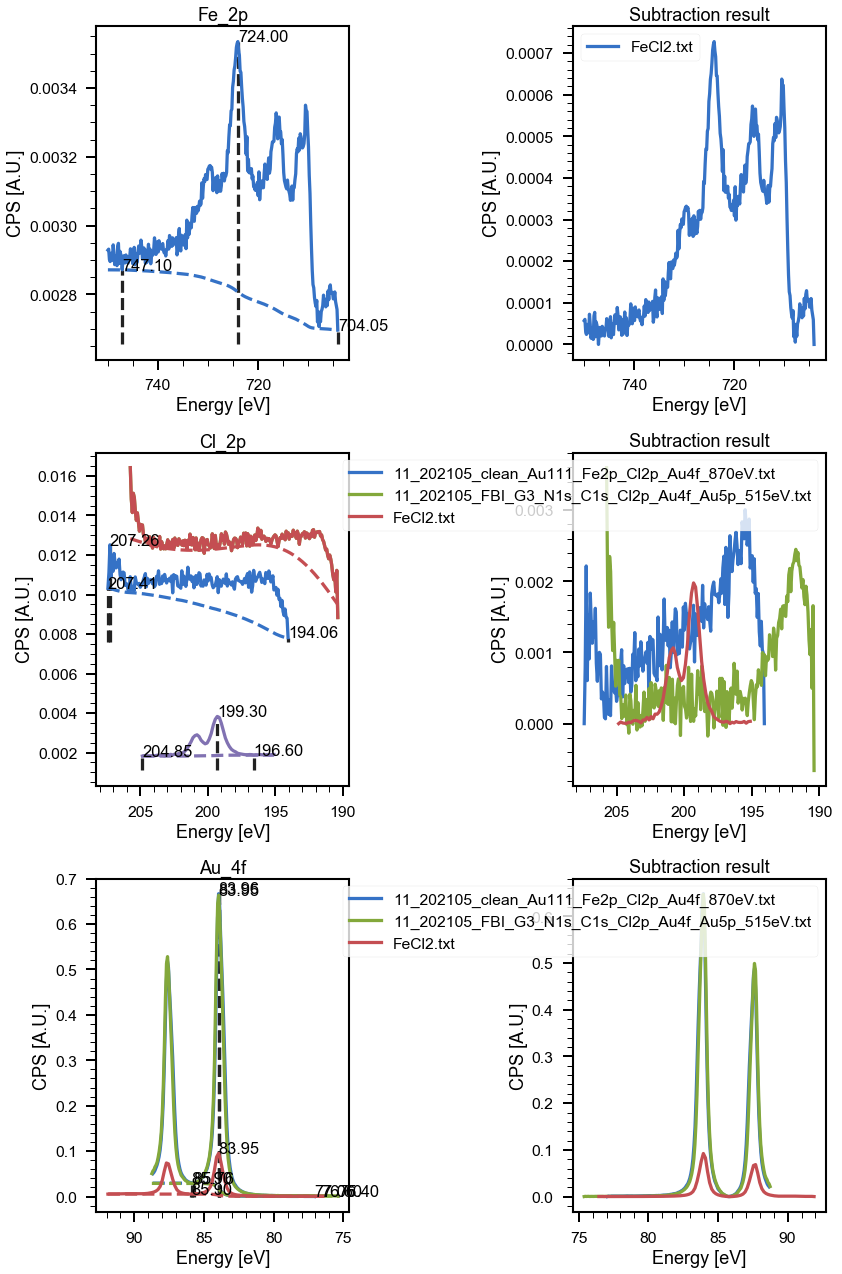

In [321]:
regions = ['Fe_2p', 'Cl_2p', 'Au_4f']

bg = bulk_bg_subtract([xpCleanAu, xpFBIG3_50min, xpFeCl2], regions)

[(0.5, 0.65), (85, 82)]

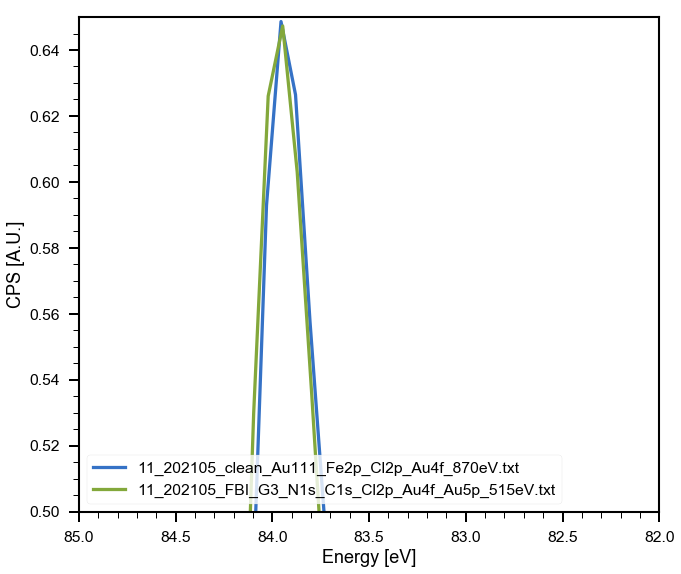

In [334]:
plot_region(bg[0], 'Au_4f')
# plot_region(xpFeCl2, 'Au_4f')
plot_region(bg[1], 'Au_4f')
plt.gca().set(xlim=(85, 82), ylim=(0.5, 0.65))

## Stoichiometry

In [277]:
[xp.name for xp in bg]

['11_202105_clean_Au111_Fe2p_Cl2p_Au4f.txt',
 '11_202105_FBI_G3_N1s_C1s_Cl2p_Au4f_Au5p.txt',
 'FeCl2.txt']

In [278]:
bg[2].area={}

[0.003697312629317907, 0.003697312629317907]

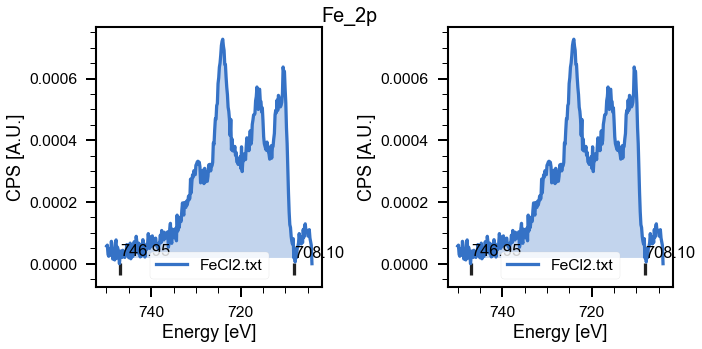

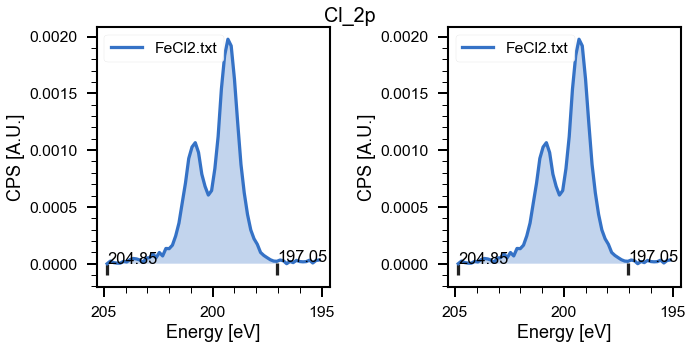

In [281]:
integrateRegions([bg[2], bg[2]], region='Fe_2p',eup=747, edw=708, asf=asf870)
integrateRegions([bg[2], bg[2]], region='Cl_2p', eup=205, edw=197, asf=asf870)

In [282]:
num = ['Cl_2p']#, 'C_1s', 'O_1s_(2)', 'Ba_3d', 'Cl_2p']
denom = ['Fe_2p']#, 'N_1s', 'N_1s', 'N_1s', 'Ba_3d']
display_stoichiometry(bg[2:], num, denom)

## Coverage

[0.8608361158285174, 0.8608361158285174]

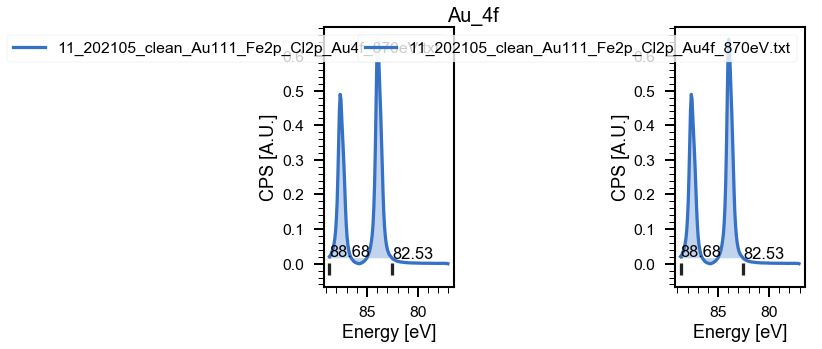

In [326]:
integrateRegions([bg[0], bg[0]], region='Au_4f', eup=88.7, edw=82.5, asf=asf870)

[0.8481251024545619, 0.8481251024545619]

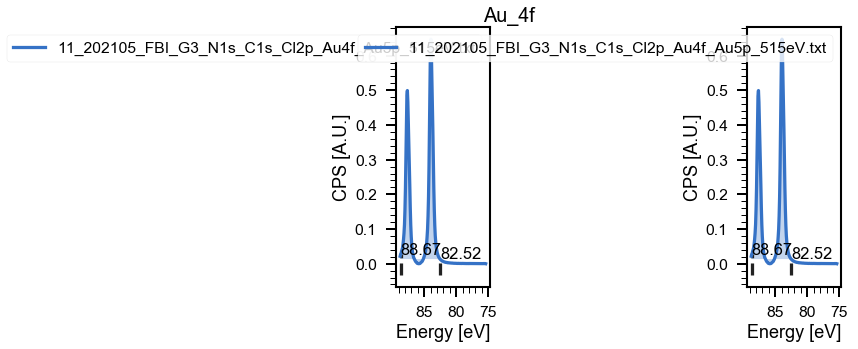

In [327]:
integrateRegions([bg[1], bg[1]], region='Au_4f', eup=88.7, edw=82.5, asf=asf515)

### IMFP FBI-G3 @ 515 - 84 eV: λ (431 eV) = 1.53 nm

In [336]:
arrange_coverages(bg, [[1,0]], r_ml=1.1, region='Au_4f', mfp=1.53, takeoff=10)

matrix([[0.82346627, 2.0431549 ]])

## Store processed experiment

In [149]:
direc, filename = os.path.split(files[0])
newpath = direc+'/proc/'

try:
    os.mkdir(newpath)
except FileExistsError: pass

In [150]:
write_processed_xp(newpath +filename.replace('.txt', '.uxy'), bg[0])